# Prepare Data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lqns-dict-batch-1/LQNS_dict_batch_1.dat
/kaggle/input/dct-au-19/DICT_Au_19.dat
/kaggle/input/dct-au-200/DICT_Au_200.dat
/kaggle/input/lq0-dict-batch-1/LQ0_dict_batch_1.dat


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import pickle
import gzip
import time
from tqdm import tqdm
import seaborn as sns
from scipy.stats import moment, kurtosis, skew
from scipy.ndimage import gaussian_filter1d

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.optim import Adam

import xgboost as xgb


In [4]:
data_path = '/kaggle/input/lq0-dict-batch-1/LQ0_dict_batch_1.dat'
with open(data_path, "rb") as pf:
    Data = pickle.load(pf)
    
data_path_2 = '/kaggle/input/lqns-dict-batch-1/LQNS_dict_batch_1.dat'
with open(data_path_2, "rb") as pf:
    Data2 = pickle.load(pf)
    
data_path_3 = '/kaggle/input/dct-au-19/DICT_Au_19.dat'
with open(data_path_3, "rb") as pf:
    Data3 = pickle.load(pf)
    
data_path_4 = '/kaggle/input/dct-au-200/DICT_Au_200.dat'
with open(data_path_4, "rb") as pf:
    Data4 = pickle.load(pf)

In [5]:
Dcts = []
Dcts.append(Data)
Dcts.append(Data4)
Dcts.append(Data3)

In [11]:
def load(Dct, Nuc, cent, charge, Ncurve = -1):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"]
    Yfin = Dct[Nuc][cent][charge]["FINAL"]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin

In [6]:
def load_sample(Dct, Nuc, cent, charge, Ncurve=2000):
    #Dct = Data
    Yin = Dct[Nuc][cent][charge]["INITIAL"][:Ncurve]
    Yfin = Dct[Nuc][cent][charge]["FINAL"][:Ncurve]
    Xin = Dct[Nuc]["INITIAL_eta"] 
    Xfin = Dct[Nuc]["FINAL_eta"] 
    return Xin, Yin, Xfin, Yfin

In [7]:
Xin_Ru = Data['Ru']['INITIAL_eta']
Xfin_Ru = Data['Ru']['FINAL_eta']

Xin_Zr = Data['Zr']['INITIAL_eta']
Xfin_Zr = Data['Zr']['FINAL_eta']

Xin_Au = Data3['Au']['INITIAL_eta']
Xfin_Au = Data3['Au']['FINAL_eta']

ON FULL DATA

In [12]:
import numpy as np

# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin = []
all_Yfin = []
all_Xin = []
all_Xfin = []
all_Nuc = []
all_cent = []
all_charge = []

for i, Data in enumerate(Dcts):
    # Iterate through the dictionary
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                        # Load Xin, Yin, Xfin, Yfin using the load function
                        Xin, Yin, Xfin, Yfin = load(Data, Nuc, cent, charge)
                        
                        # Add 200 to each array in Yin
                        if i <=1:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 200)))
                        else:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 19)))
                        
                        #print(Yin.shape)
                        # Append to the lists along with identifiers
                        all_Yin.append(Yin)
                        all_Yfin.append(Yfin)
                        all_Xin.append(Xin)
                        all_Xfin.append(Xfin)
                        all_Nuc.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                        all_cent.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                        all_charge.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_full = np.concatenate(all_Yin, axis=0)  # Assuming concatenation is appropriate
all_Yfin_full = np.concatenate(all_Yfin, axis=0)
all_Nuc_full = np.array(all_Nuc)
all_cent_full = np.array(all_cent)
all_charge_full = np.array(all_charge)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_full.shape)
print("Shape of all_Yfin:", all_Yfin_full.shape)
print("Shape of all_Nuc:", all_Nuc_full.shape)
print("Shape of all_cent:", all_cent_full.shape)
print("Shape of all_charge:", all_charge_full.shape)

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_full = nuc_one_hot_encoder.fit_transform(all_Nuc_full.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_full = charge_one_hot_encoder.fit_transform(all_charge_full.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_full = cent_one_hot_encoder.fit_transform(all_cent_full.reshape(-1, 1))

# Concatenate features
X_features = np.concatenate([all_Yin_full, all_Nuc_encoded_full, all_charge_encoded_full], axis=1)

# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train_1, X_test_1, y_train_1, y_test_1, all_cent_train_1, all_cent_test_1, all_charge_train_1, all_charge_test_1 = train_test_split(
    X_features, all_Yfin_full, all_cent_encoded_full, all_charge_encoded_full, test_size=0.2, random_state=42, shuffle=True)


Shape of all_Yin: (190510, 73)
Shape of all_Yfin: (190510, 141)
Shape of all_Nuc: (190510,)
Shape of all_cent: (190510,)
Shape of all_charge: (190510,)


In [67]:
X_train_1[0]

array([0.00000000e+00, 0.00000000e+00, 5.68718997e-06, 5.65203991e-05,
       3.33426986e-04, 1.66256004e-03, 7.03606009e-03, 2.57702991e-02,
       8.17205980e-02, 2.26614997e-01, 5.55164993e-01, 1.21730995e+00,
       2.42539001e+00, 4.45605993e+00, 7.62897015e+00, 1.22118998e+01,
       1.82143002e+01, 2.51464996e+01, 3.19584007e+01, 3.73236008e+01,
       4.01585999e+01, 4.00358009e+01, 3.72552986e+01, 3.26403008e+01,
       2.72528992e+01, 2.21173000e+01, 1.79557991e+01, 1.50056000e+01,
       1.30342999e+01, 1.15676003e+01, 1.01885996e+01, 8.72200966e+00,
       7.22725010e+00, 5.87112999e+00, 4.80109978e+00, 4.08821011e+00,
       3.73478007e+00, 3.71846008e+00, 4.04211998e+00, 4.75049019e+00,
       5.88872004e+00, 7.43767023e+00, 9.29666042e+00, 1.13361998e+01,
       1.34682999e+01, 1.56813002e+01, 1.80482006e+01, 2.07219009e+01,
       2.38785992e+01, 2.75639000e+01, 3.14906006e+01, 3.49560013e+01,
       3.70225983e+01, 3.69224014e+01, 3.44376984e+01, 2.99960995e+01,
      

In [66]:
# Print mappings of the encoders
print("Nuc encoder mapping:")
for i, category in enumerate(nuc_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {nuc_one_hot_encoder.transform([[category]])[0]}")

print("\nCharge encoder mapping:")
for i, category in enumerate(charge_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {charge_one_hot_encoder.transform([[category]])[0]}")

print("\nCent encoder mapping:")
for i, category in enumerate(cent_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {cent_one_hot_encoder.transform([[category]])[0]}")


Nuc encoder mapping:
Au -> 0 -> [1. 0. 0.]
Ru -> 1 -> [0. 1. 0.]
Zr -> 2 -> [0. 0. 1.]

Charge encoder mapping:
B -> 0 -> [1. 0.]
Q -> 1 -> [0. 1.]

Cent encoder mapping:
0-10 -> 0 -> [1. 0. 0. 0. 0.]
10-20 -> 1 -> [0. 1. 0. 0. 0.]
20-40 -> 2 -> [0. 0. 1. 0. 0.]
40-60 -> 3 -> [0. 0. 0. 1. 0.]
60-80 -> 4 -> [0. 0. 0. 0. 1.]


In [9]:
y_train_2 = []
y_test_2 = []
sigma = 3
threshold = len(y_train_1) / 2

for y  in y_train_1:
    y_smoothed = gaussian_filter1d(y, sigma)
    if threshold > 0:
        y_train_2.append(y_smoothed)
    else:
        y_train_2.append(y)
    #threshold -= 1

threshold = len(y_test_1) / 2
for y in y_test_1:
    y_smoothed = gaussian_filter1d(y, sigma)
    if threshold > 0:
        y_test_2.append(y_smoothed)
    else:
        y_test_2.append(y)
    #threshold -= 1
    


In [10]:
with open('nuc_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(nuc_one_hot_encoder, f)

with open('charge_one_hot_encoder.pkl', 'wb') as f:
    pickle.dump(charge_one_hot_encoder, f)


# LINEAR REGRESSION

Moments

In [11]:
def calculate_moments_cumulants(data):
    mean = np.mean(data)
    variance = np.var(data)
    third_moment = np.mean((data - mean) ** 3)
    fourth_moment = np.mean((data - mean) ** 4)
    
    moments = {
        'mean': mean,
        'variance': variance,
        'third_moment': third_moment,
        'fourth_moment': fourth_moment
    }
    
    cumulants = {
        'mean': mean,
        'variance': variance,
        'third_cumulant': third_moment ,
        'fourth_cumulant': fourth_moment - 3 * ((variance) ** 2)
    }
    
    return moments, cumulants

Finetune

In [12]:
from matplotlib.backends.backend_pdf import PdfPages

# Initialize PdfPages globally
pdf_pages = PdfPages('plots.pdf')

def finetune(model, X_train, y_train, X_test, y_test, flag=False, scale=False):
    start_time = time.time()
    if model == lr:
        plt_title = 'Linear Regression'
    #elif model == mlp:
       # plt_title = 'MLP'
    else:
        plt_title = 'Misc'
    
    if flag:
        model.fit(X_train[:, :72], y_train)
        y_pred = model.predict(X_test[:, :72])
    else:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        #for i in range(10):
            #y_pred_ = model.predict(X_test)
            
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    sample_index = np.random.randint(1, len(X_test))
    y1_plot = X_test[sample_index, :72]
    y1 = X_test[sample_index]
    y2 = y_test_1[sample_index]
    
    if y1[-3] == 0.0 and y1[-4] == 1.0:
        xaxes1 = Xin_Ru
        xaxes2 = Xfin_Ru
    else:
        xaxes1 = Xin_Zr
        xaxes2 = Xfin_Zr

    if flag:
        y1 = y1[:72]
        y2_pred = model.predict([y1])[0]
    else:
        
        y2_pred = model.predict([y1])[0]
        initial = sum(y1[:72])
        final_pred = sum(y2)
        final_actual = sum(y2_pred)
        print(len(y2_pred))

        plt.plot(xaxes1, y1_plot, 'r', label='Initial')
        plt.plot(xaxes2, y2, 'b', label='Final')
        plt.plot(xaxes2, y2_pred, 'k', label='Predicted')
        plt.xlabel(r'$\eta_s, \eta$')
        plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')
        plt.legend()
        plt.title('Prediction for: '+ plt_title)

        # Save current plot to the PdfPages object
        #pdf_pages.savefig()
        plt.show()
        
        print('initial:',initial /71 * (max(xaxes1) - min(xaxes1)))
        print('final_pred: ', final_pred / 140 * (max(xaxes2) - min(xaxes2)))
        print('final_actual: ',final_actual / 140 * (max(xaxes2) - min(xaxes2)))
            

# Function to close the PdfPages object
def close_pdf():
    pdf_pages.close()
    print("PDF file closed.")

# close_pdf()


Histograms

In [13]:
# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for histograms
def plot_histograms(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels

    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)

    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred = model.predict([y1])

                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)
                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 0.5 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)


Error Scatterplots

In [14]:
# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for error norm scatter plots
def plot_error_norm(model, X_test, y_test, all_cent_test, all_charge_test,y_test2,flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []
            cent_Yfin_actual = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]
                Yfin2 = y_test2[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)
                    cent_Yfin_actual.append(Yfin2)


            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)
            cent_Yfin_actual = np.array(cent_Yfin_actual)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            std_dev_actual = []
            error_norm = []

            check += len(cent_Yin)
            plot_check = 0
            for k in range(len(cent_Yin)):#iterating the test data
                y1 = cent_Yin[k]#one event in the test data
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_f = cent_Yfin_actual[k]#actual final state of the event
                y2_pred = model.predict([y1])#predicted final state of the event

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])#sum of preds
                integrated_value_actual = np.sum(y2_f[indices])/len(y2_pred[0][indices])#sum of actual
                std_dev = np.std(y2_f[indices])
                std_dev_actual.append(std_dev)#std of actual
                error = (integrated_value_pred - integrated_value_actual) / std_dev#error
                error_norm.append(error)#list of errors for all the events
                
                
                if abs(error) > 1:
                     error_count_cent += 1
                """
                    plot_check += 1
                    print(y1[-4], y1[-3])
                    # Example x-axis values
                    if y1[-3] == 0.0 and y1[-4] == 1.0:
                        xaxes1 = Xin_Ru
                        xaxes2 = Xfin_Ru
                        print('Ru')
                    else:
                        xaxes1 = Xin_Zr
                        xaxes2 = Xfin_Zr
                        print('Zr')
                    #print(xaxes1, xaxes2)
                    if flag:
                        y1 = y1[:72]
                        y2_pred = model.predict([y1])[0]
                    else:
                        y2_pred = model.predict([y1])[0]

                    # Plotting
                    plt.figure(figsize = (5,5))
                    plt.plot(xaxes1, y1[:72], 'r', label='Initial')
                    plt.plot(xaxes2, y2, 'b', label='Final')
                    plt.plot(xaxes2, y2_pred, 'k', label='Predicted')
                    plt.plot(xaxes2[indices], y2_pred[indices], 'g', linewidth = 4, alpha = 0.5)
                    plt.plot(xaxes2[indices], y2[indices], 'y', linewidth = 4, alpha = 0.5)
                    plt.legend()
                    plt.xlabel('X-axis label') 
                    plt.ylabel('Y-axis label')  
                    if plot_check < 3:
                        plt.show()
                """

                verbose = True

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            plt.scatter(range(len(error_norm)), error_norm, alpha=0.5, label=f'Error Norm {charge_type}')
            #plt.hist(error_norm, alpha=0.5, density = True)
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count +=  error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)
        
    print("Total >1 std dev:", error_count)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined
#plot_error_norm(lr2, X_test, y_test, all_cent_test, all_charge_test)

#plot_error_norm(lr, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)



In [15]:
def plot_error_norm_11(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -7
            x_range_max = 7

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]

            std_dev_actual = []
            error_norm = []
            std_dev_smooth = []
            error_smooth = []
            p = []
            a_s = []
            a = []
            

            check += len(cent_Yin)

            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred = model.predict([y1])
                

                # Apply smoothing to y2
                sigma = 3
                y2_smooth = gaussian_filter1d(y2, sigma)

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])
                integrated_value_actual = np.sum(y2[indices]) / len(y2_pred[0][indices])
                integrated_value_smooth = np.sum(y2_smooth[indices]) / len(y2_pred[0][indices])
                p.append(integrated_value_pred)
                a_s.append(integrated_value_smooth)
                a.append(integrated_value_actual)
                

                std_dev = np.std(y2[indices])
                std_dev_actual.append(std_dev)
                error = (integrated_value_pred - integrated_value_actual) / std_dev
                error_norm.append(error)

                std_dev_s = np.std(y2_smooth[indices])
                std_dev_smooth.append(std_dev_s)
                error_s = (integrated_value_pred - integrated_value_smooth) / std_dev_s
                error_smooth.append(error_s)

                if abs(error_s) > 1:
                    error_count_cent += 1

                verbose = True

            # Ensure error_smooth is a numpy array if not already
            error_smooth = np.array(error_smooth)

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            #plt.scatter(range(len(error_smooth)), error_smooth, alpha=0.5, label=f'Error Norm {charge_type}')
            plt.scatter(p, a_s, label='Smoothed_A')
            plt.scatter(p, a, alpha=0.5, label=f'A')
            
            #plt.hist(error_smooth)
            #plt.hist(error_norm, alpha = 0.7)
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count += error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)

    print("Total >1 std dev:", error_count)


Training completed in 1.77 seconds.
Mean Squared Error: 0.8759581697630001
141


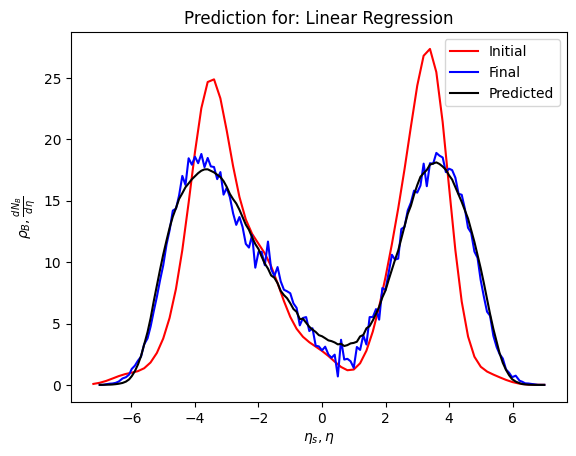

initial: 116.990998201159
final_pred:  119.34874965138732
final_actual:  120.33922099630351


"\nmodel_path = 'LR.pkl.gz'\nwith gzip.open(model_path, 'wb') as f:\n    pickle.dump(lr, f)\n# Load the model\nwith gzip.open(model_path, 'rb') as f:\n    lr_model = pickle.load(f)\n"

In [16]:
lr = LinearRegression()
finetune(lr, X_train_1, y_train_1, X_test_1, y_test_1)
#plot_histograms(lr, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

# Save the model
'''
model_path = 'LR.pkl.gz'
with gzip.open(model_path, 'wb') as f:
    pickle.dump(lr, f)
# Load the model
with gzip.open(model_path, 'rb') as f:
    lr_model = pickle.load(f)
'''


Training completed in 1.82 seconds.
Mean Squared Error: 0.3646600491635535
141


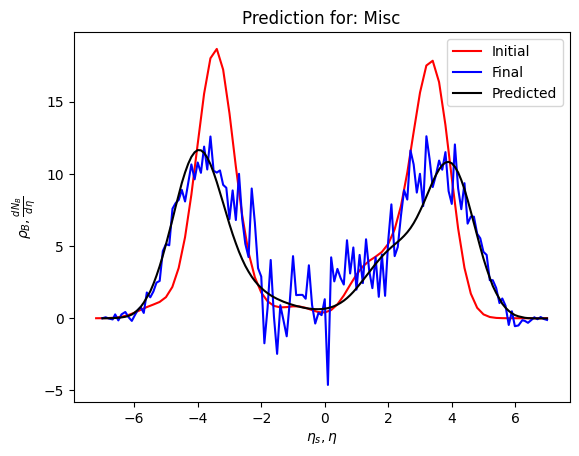

initial: 64.99992933494204
final_pred:  62.15332824662328
final_actual:  56.665655143661766


In [17]:
lr2 = LinearRegression()
finetune(lr2, X_train_1, y_train_2, X_test_1, y_test_2)
#plot_histograms(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)
#plot_error_norm(lr2, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1, y_test_1)
model_path = 'LR.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(lr2, f)
# Load the model
with open(model_path, 'rb') as f:
    lr_model = pickle.load(f)


Poly Ridge

Training completed in 24.66 seconds.
Mean Squared Error: 0.20233599033158461
141


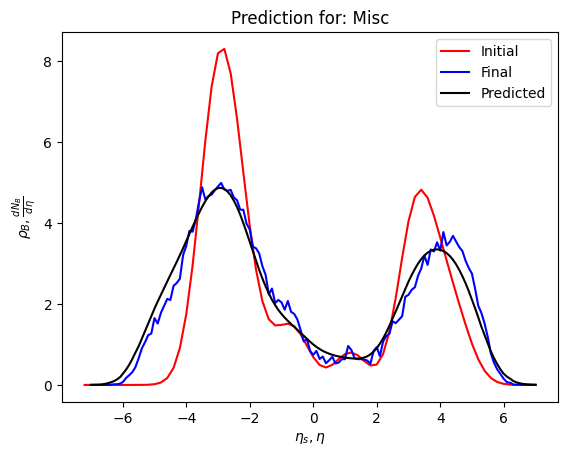

initial: 25.999985177605264
final_pred:  26.551904580998233
final_actual:  26.752190287798065


In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
import pickle

# Generate and fit polynomial features with Ridge regression
pipeline = make_pipeline(
    PolynomialFeatures(degree=2),
    Ridge(alpha=2.0)
)

# Fit the pipeline to the training data
finetune(pipeline, X_train_1, y_train_2, X_test_1, y_test_2)

# Save the entire pipeline
model_path = 'newRD.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(pipeline, f)


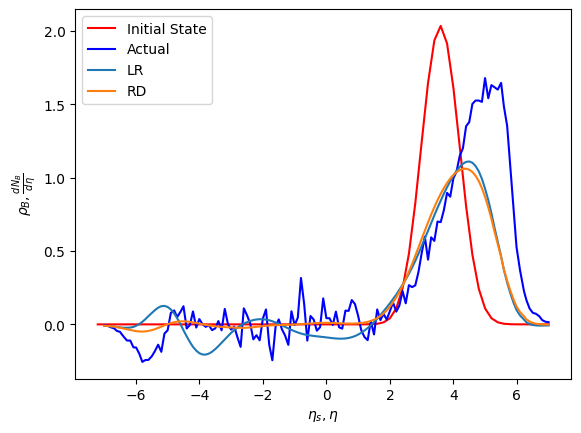

Mean Squared Error: 125.2560806274414
Pearson Correlation Coefficient: 0.07040538466124414


In [19]:
# Extract a random sample from the test data
random_index = np.random.randint(0, len(X_test_1))
X_sample = X_test_1[random_index]
y_actual = y_test_1[random_index]
y_actual_2 = y_test_2[random_index]
#X_sample_2 = X_test_poly[random_index]

sigma = 3 # Adjust sigma as needed
#y_smoothed = gaussian_filter1d(y_actual, sigma)

y_pred_lr = lr.predict([X_sample])
y_pred_lr2 = lr2.predict([X_sample])
y_pred_ridge = pipeline.predict([X_sample])

#y_pred_sample = smooth_predictions(y_pred_sample)

# Assuming xaxes1 and xaxes2 are the same for all samples
# Update these based on your actual data if they vary
if X_sample[-3] == 0.0 and X_sample[-4] == 1.0:
    xaxes1 = Xin_Ru
    xaxes2 = Xfin_Ru
else:
    xaxes1 = Xin_Zr
    xaxes2 = Xfin_Zr

#plt.subplot(1, 2)
# Plot the initial state, actual final state, and predicted final state
plt.plot(xaxes1, X_sample[:72], 'r', label='Initial State')
plt.plot(xaxes2, y_actual, 'b', label='Actual')
#plt.plot(xaxes2, y_actual_2, label='Actual_smooth')
#plt.plot(xaxes2, y_smoothed, 'g', label='Smooth')
#plt.plot(xaxes2, y_pred_lr[0], 'k', label='LR')
plt.plot(xaxes2, y_pred_lr2[0], label='LR')
plt.plot(xaxes2, y_pred_ridge[0], label='RD')
plt.legend()
plt.xlabel(r'$\eta_s, \eta$')  # X-axis label with LaTeX formatting
plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')  # Y-axis label with LaTeX formatting
#plt.title('Random Sample Event with Initial, Final, and Predicted States')
plt.show()



# Calculate Mean Squared Error
mse = np.mean((y_actual - y_smoothed)**2)
print(f"Mean Squared Error: {mse}")

# Calculate Pearson Correlation Coefficient
corr = np.corrcoef(y_actual, y_smoothed)[0, 1]
print(f"Pearson Correlation Coefficient: {corr}")


# MLP

In [20]:
mlp = MLPRegressor(max_iter = 500, hidden_layer_sizes = (100, 100), random_state = 42)
#finetune(mlp, X_train_1, y_train_1, X_test_1, y_test_1)
#plot_error_norm(mlp, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)
#plot_histograms(mlp, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

# NN

In [21]:

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors and move to the device
X_train_tensor = torch.FloatTensor(X_train_1).to(device)
y_train_tensor = torch.FloatTensor(y_train_1).to(device)
X_test_tensor = torch.FloatTensor(X_test_1).to(device)
y_test_tensor = torch.FloatTensor(y_test_1).to(device)

y_train_tensor_2 = torch.FloatTensor(y_train_2).to(device)
y_test_tensor_2 = torch.FloatTensor(y_test_2).to(device)

/tmp/ipykernel_34/2635860447.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  y_train_tensor_2 = torch.FloatTensor(y_train_2).to(device)


In [22]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error


# Define the model
model_nn = nn.Sequential(
    nn.Linear(X_train_1.shape[1], 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, y_train_1.shape[1])
).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = Adam(model_nn.parameters())

# Train the model
for epoch in range(500):
    # Forward pass
    outputs = model_nn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor_2)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Predict on test data
model_nn.eval()
with torch.no_grad():
    y_pred_tensor = model_nn(X_test_tensor)

# Convert to numpy arrays
y_test = y_test_tensor_2.cpu().numpy()
y_pred = y_pred_tensor.cpu().numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.3141152262687683


Histograms

In [23]:
def plot_histograms_nn(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]

                # Prepare the input for the model
                y1_tensor = torch.FloatTensor([y1]).to(device)
                model.eval()
                with torch.no_grad():
                    y2_pred_tensor = model(y1_tensor)
                y2_pred = y2_pred_tensor.cpu().numpy()

                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)

                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 3 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined



Error Scatterplots

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

# Plotting function for error norm scatter plots
def plot_error_norm_nn(model, X_test, y_test, all_cent_test, all_charge_test , flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            std_dev_actual = []
            error_norm = []

            check += len(cent_Yin)
            plot_check = 0
            for k in range(len(cent_Yin)):  # Iterating the test data
                y1 = cent_Yin[k]  # One event in the test data
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]  # Actual final state of the event

                # Prepare the input for the model
                y1_tensor = torch.FloatTensor([y1]).to(device)
                model.eval()
                with torch.no_grad():
                    y2_pred_tensor = model(y1_tensor)
                y2_pred = y2_pred_tensor.cpu().numpy()  # Predicted final state of the event

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])  # Sum of preds
                integrated_value_actual = np.sum(y2[indices]) / len(y2_pred[0][indices])  # Sum of actual
                std_dev = np.std(y2[indices])
                std_dev_actual.append(std_dev)  # Std of actual
                error = (integrated_value_pred - integrated_value_actual) / std_dev  # Error
                error_norm.append(error)  # List of errors for all the events

                if abs(error) > 1:
                    error_count_cent += 1

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            plt.scatter(range(len(error_norm)), error_norm, alpha=0.5, label=f'Error Norm {charge_type}')
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count += error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)

    print("Total >1 std dev:", error_count)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined



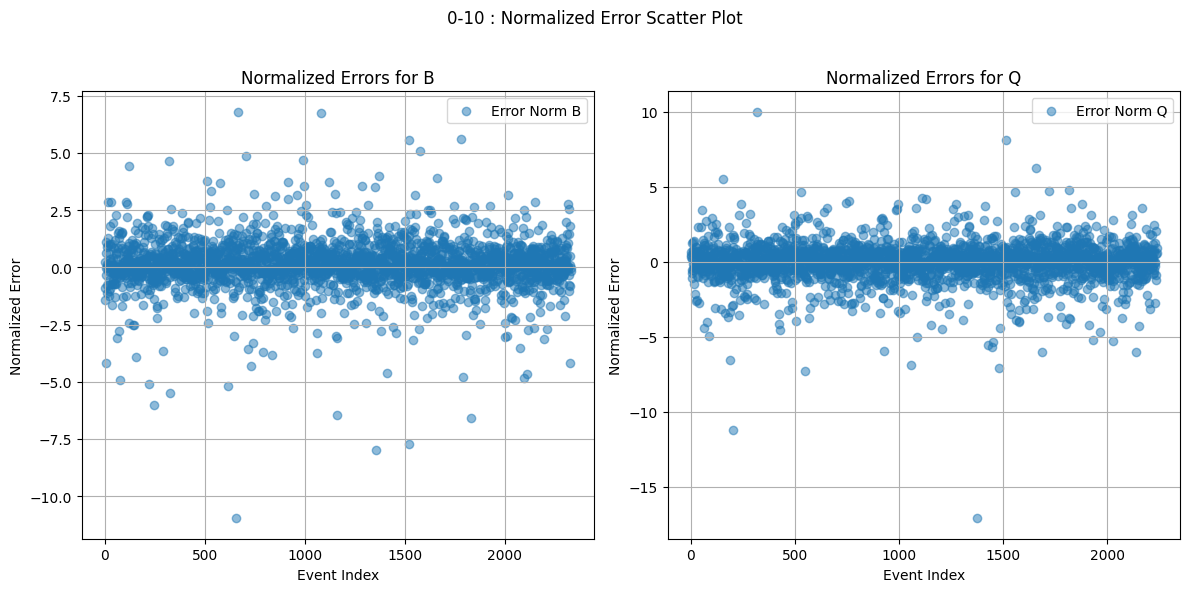

X_test: 38102
Check: 4571
Total >1 std dev: 1183


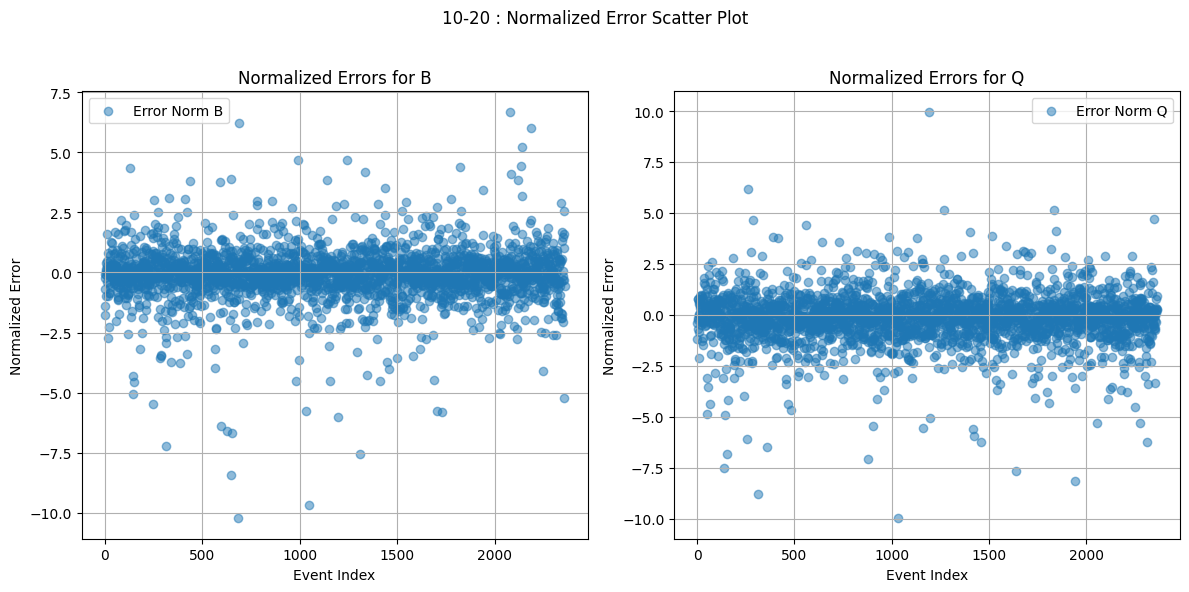

X_test: 38102
Check: 9293
Total >1 std dev: 1244


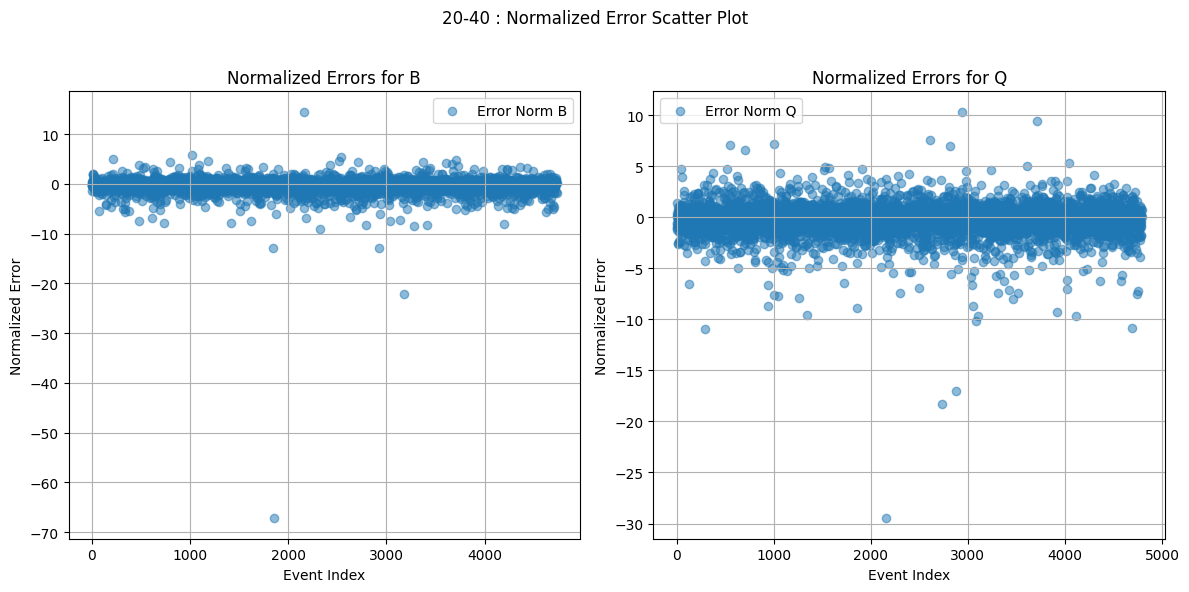

X_test: 38102
Check: 18820
Total >1 std dev: 2713


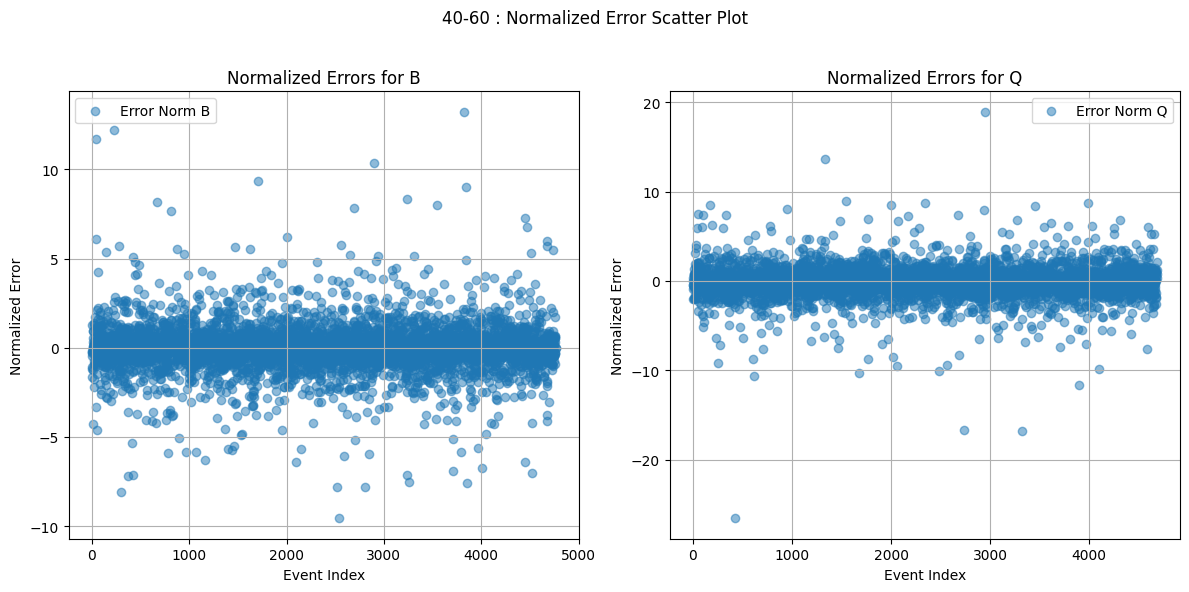

X_test: 38102
Check: 28268
Total >1 std dev: 2960


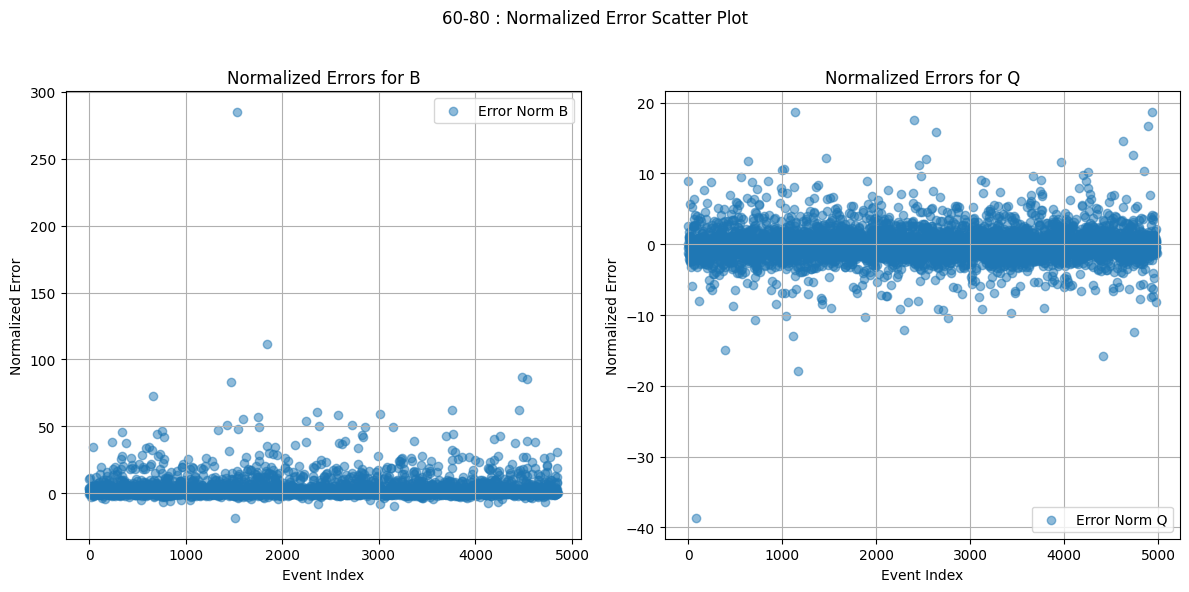

X_test: 38102
Check: 38102
Total >1 std dev: 4729
Total >1 std dev: 18517


In [25]:
plot_error_norm_nn(model_nn, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)
#plot_histograms_nn(model_nn, X_test_1, y_test_2, all_cent_test_1, all_charge_test_1)

# NN 2

In [26]:
import torch
from torch import nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors and move to the device
X_train_tensor = torch.FloatTensor(X_train_1).to(device)
y_train_tensor = torch.FloatTensor(y_train_2).to(device)
X_test_tensor = torch.FloatTensor(X_test_1).to(device)
y_test_tensor = torch.FloatTensor(y_test_2).to(device)

# Define the model with BatchNorm and Dropout
class RegressionNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(RegressionNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LeakyReLU(negative_slope=0.2),  # Example of Leaky ReLU
            nn.BatchNorm1d(512),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.ELU(),  # Example of ELU
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.PReLU(),  # Example of PReLU
            nn.BatchNorm1d(64),
            # nn.Dropout(0.1),  # Optional dropout
            nn.Linear(64, output_dim)
        )
    
    def forward(self, x):
        return self.network(x)


# Initialize the model, loss function, and optimizer
model_nn = RegressionNN(X_train_1.shape[1], y_train_1.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = Adam(model_nn.parameters(), lr=0.001)  # Use SGD with momentum

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

# Define L1 regularization strength
l1_lambda = 0.000001

# Training loop with early stopping
num_epochs = 1000
early_stop_patience = 20
best_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model_nn.train()
    outputs = model_nn(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Add L1 regularization
    l1_norm = sum(p.abs().sum() for p in model_nn.parameters())
    loss += l1_lambda * l1_norm
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model_nn.eval()
    with torch.no_grad():
        val_outputs = model_nn(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
    
    scheduler.step(val_loss)
    
    if val_loss < best_loss:
        best_loss = val_loss
        epochs_no_improve = 0
        best_model = model_nn.state_dict()
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    if epoch % 50 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

# Load the best model
model_nn.load_state_dict(best_model)

# Predict on test data
model_nn.eval()
with torch.no_grad():
    y_pred_tensor = model_nn(X_test_tensor)

# Convert to numpy arrays
y_test = y_test_tensor.cpu().numpy()
y_pred = y_pred_tensor.cpu().numpy()

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")




Epoch 1/1000, Training Loss: 42.95109939575195, Validation Loss: 41.18711853027344
Epoch 51/1000, Training Loss: 25.763856887817383, Validation Loss: 24.88132667541504
Epoch 101/1000, Training Loss: 17.13863754272461, Validation Loss: 16.527141571044922
Epoch 151/1000, Training Loss: 12.025979042053223, Validation Loss: 12.647100448608398
Epoch 201/1000, Training Loss: 8.169774055480957, Validation Loss: 8.522772789001465
Epoch 251/1000, Training Loss: 4.8553643226623535, Validation Loss: 5.208065032958984
Epoch 301/1000, Training Loss: 2.44710636138916, Validation Loss: 2.5131173133850098
Epoch 351/1000, Training Loss: 1.1520233154296875, Validation Loss: 1.183669924736023
Epoch 401/1000, Training Loss: 0.6408898234367371, Validation Loss: 0.5561988949775696
Epoch 451/1000, Training Loss: 0.4565031826496124, Validation Loss: 0.38247501850128174
Epoch 501/1000, Training Loss: 0.3960449695587158, Validation Loss: 0.3081696331501007
Epoch 551/1000, Training Loss: 0.3689609169960022, Vali

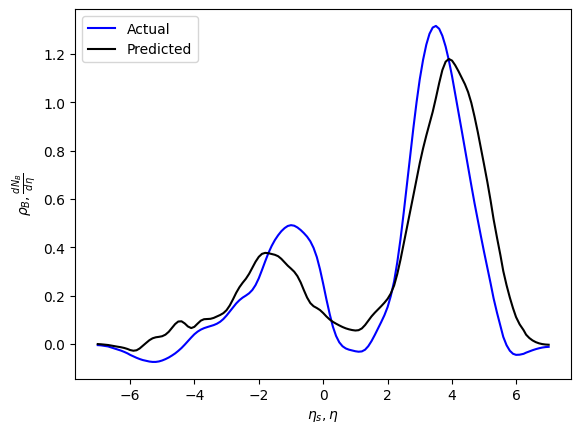

In [27]:
# Ensure the model is in evaluation mode
model_nn.eval()

# Extract a random sample from the test data
random_index = np.random.randint(0, X_test_tensor.shape[0])
X_sample = X_train_tensor[random_index].unsqueeze(0)  # Add batch dimension
y_actual = y_train_tensor_2[random_index].cpu().numpy()


sigma = 2 # 4.5, 2, 2,5
y_smoothed = gaussian_filter1d(y_actual, sigma)

# Make a prediction using the trained model
with torch.no_grad():
    y_pred_sample = model_nn(X_sample).cpu().numpy()
    y_pred_sample = gaussian_filter1d(y_pred_sample, sigma)

#y_pred_sample = smooth_predictions(y_pred_sample)

# Assuming xaxes1 and xaxes2 are the same for all samples
# Update these based on your actual data if they vary
if X_sample[0, -3] == 0.0 and X_sample[0, -4] == 1.0:
    xaxes1 = Xin_Ru
    xaxes2 = Xfin_Ru
else:
    xaxes1 = Xin_Zr
    xaxes2 = Xfin_Zr

# Plot the initial state, actual final state, and predicted final state
#plt.plot(xaxes1, X_sample.cpu().numpy()[0][:72], 'r', label='Initial State')
plt.plot(xaxes2, y_actual, 'b', label='Actual')
#plt.plot(xaxes2, y_smoothed, 'g', label='Smooth')
plt.plot(xaxes2, y_pred_sample[0], 'k', label='Predicted')
plt.legend()
plt.xlabel(r'$\eta_s, \eta$')  # X-axis label with LaTeX formatting
plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')  # Y-axis label with LaTeX formatting
#plt.title('Random Sample Event with Initial, Final, and Predicted States')
plt.show()


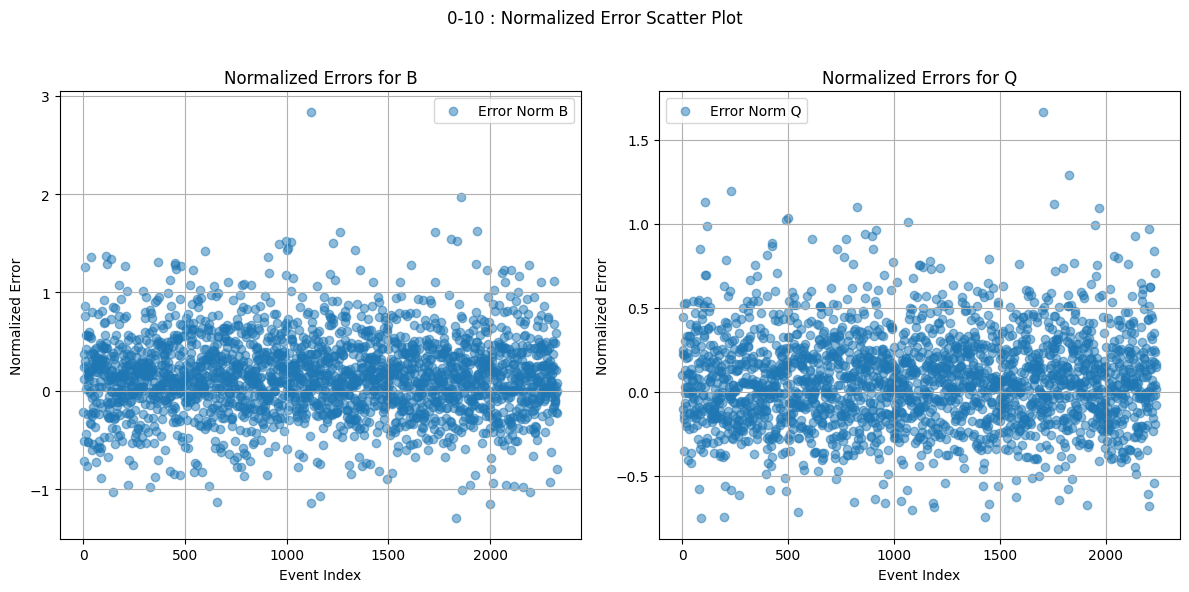

X_test: 38102
Check: 4571
Total >1 std dev: 81


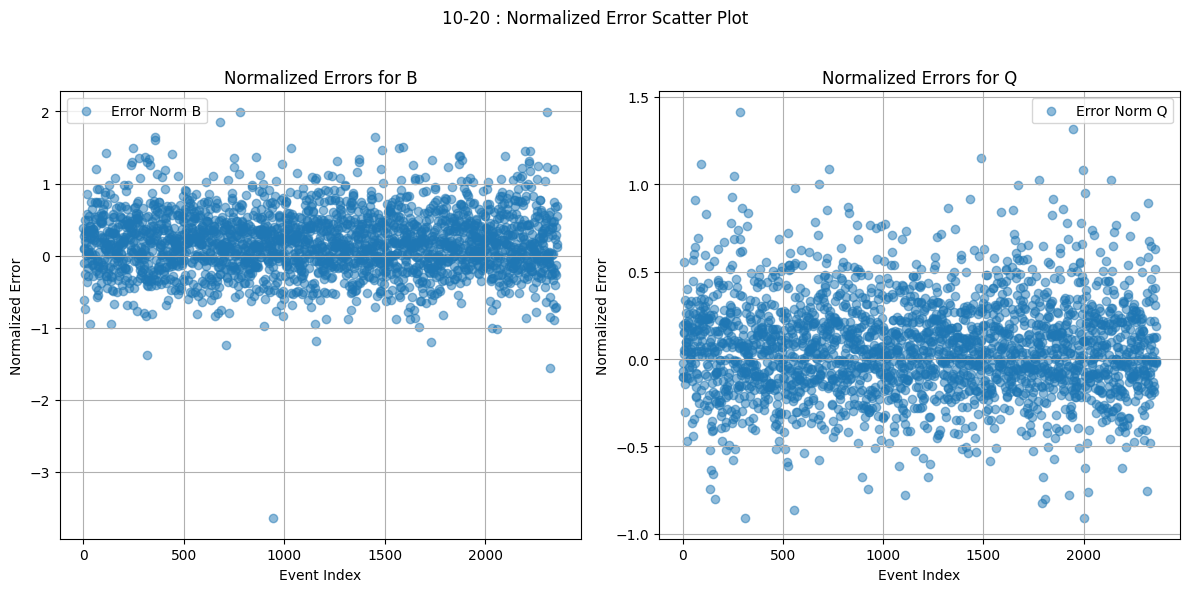

X_test: 38102
Check: 9293
Total >1 std dev: 101


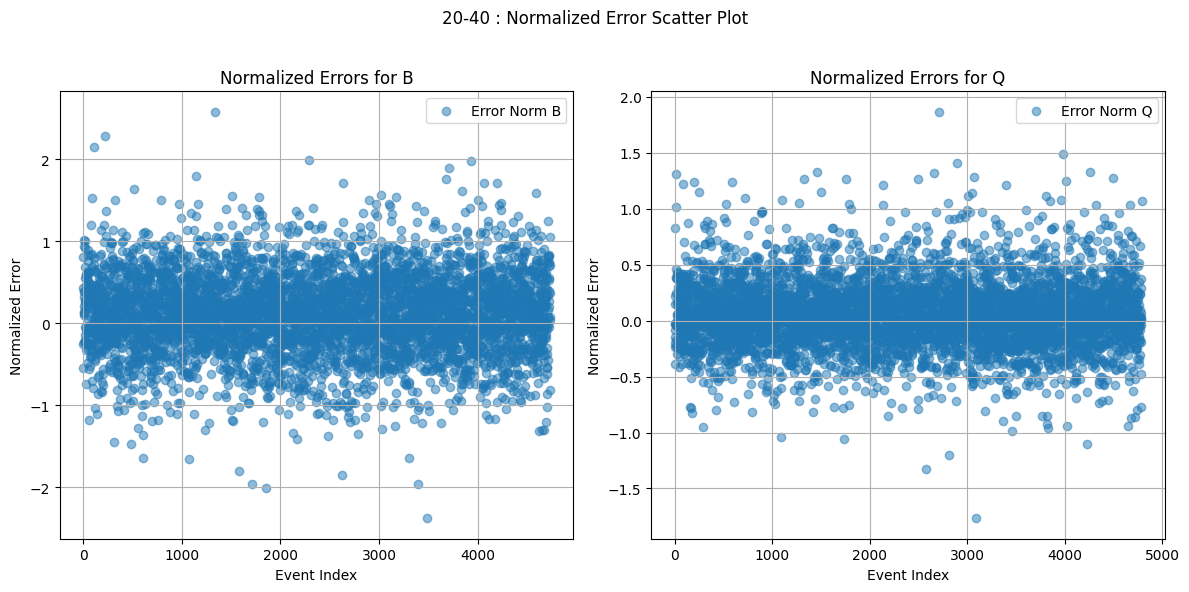

X_test: 38102
Check: 18820
Total >1 std dev: 268


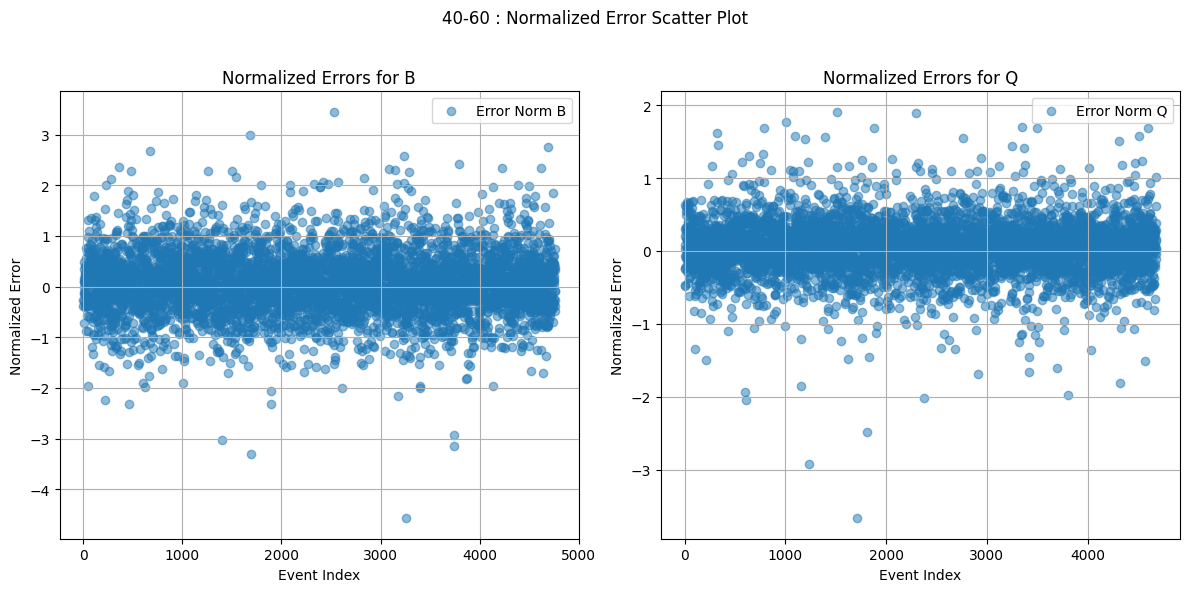

X_test: 38102
Check: 28268
Total >1 std dev: 588


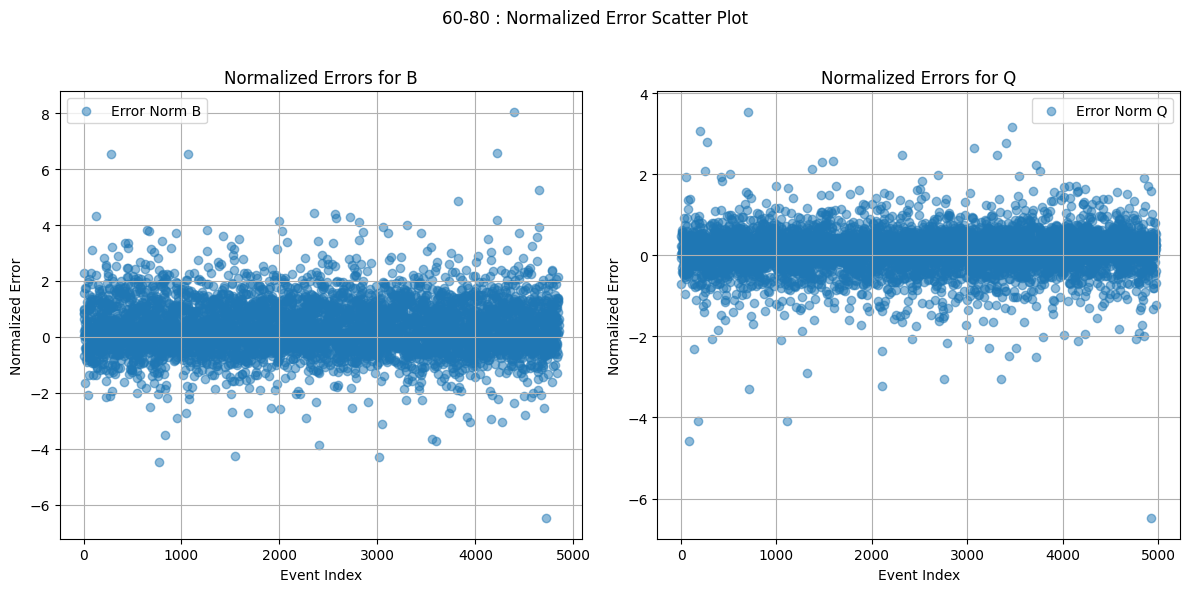

X_test: 38102
Check: 38102
Total >1 std dev: 1602
Total >1 std dev: 4832
0
actual 2332
pred 2332
1
actual 2239
pred 2239


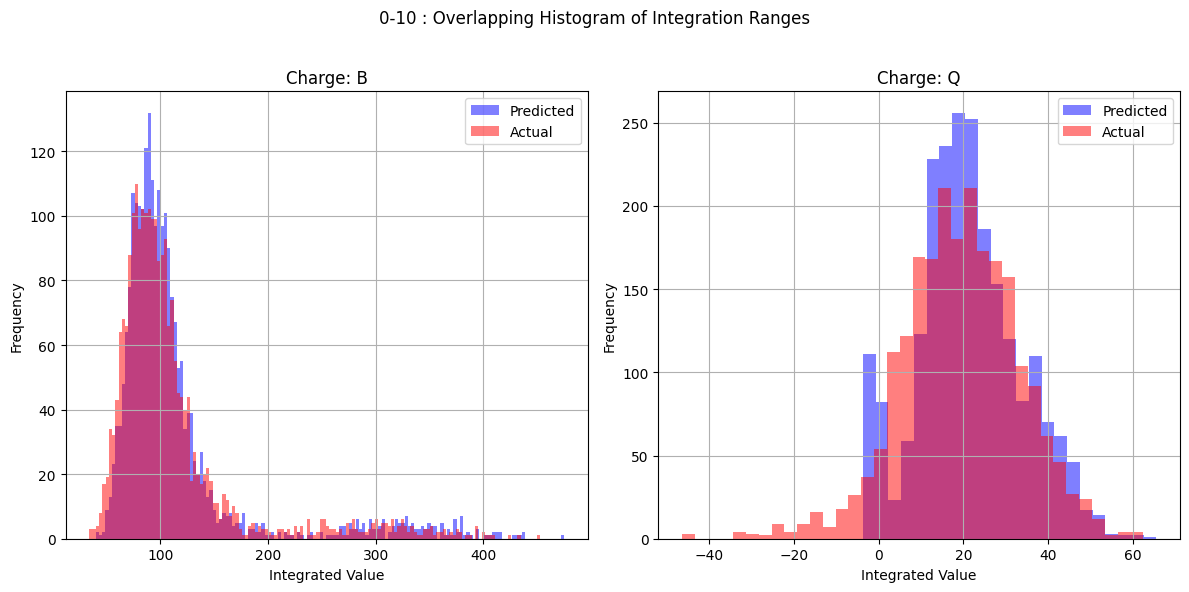

X_test: 38102
Check: 4571
0
actual 2358
pred 2358
1
actual 2364
pred 2364


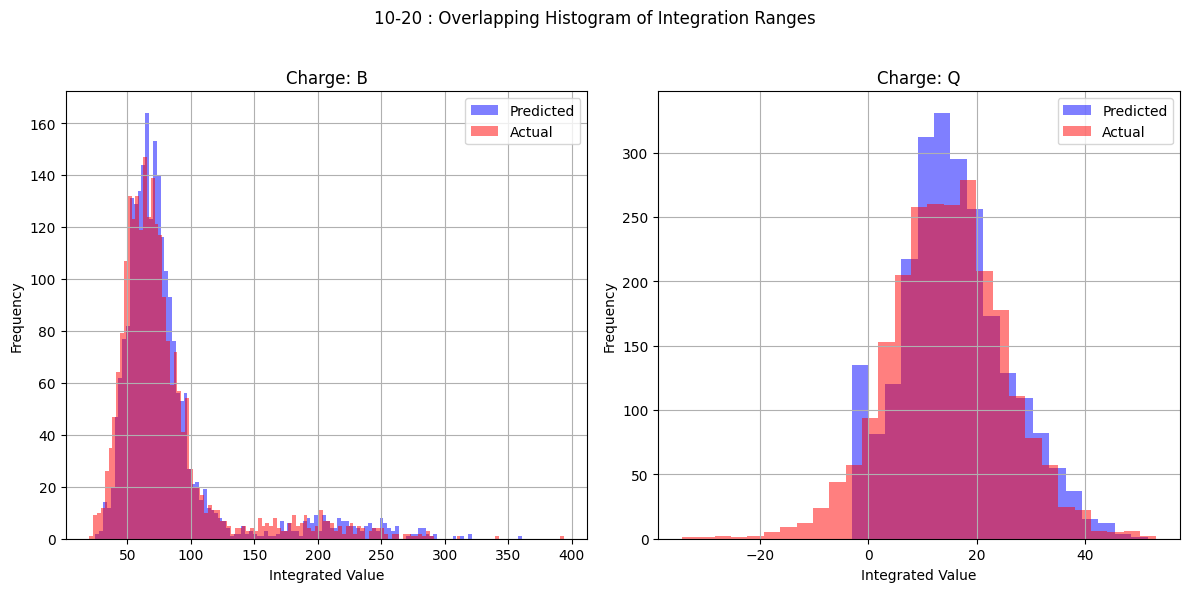

X_test: 38102
Check: 9293
0
actual 4736
pred 4736
1
actual 4791
pred 4791


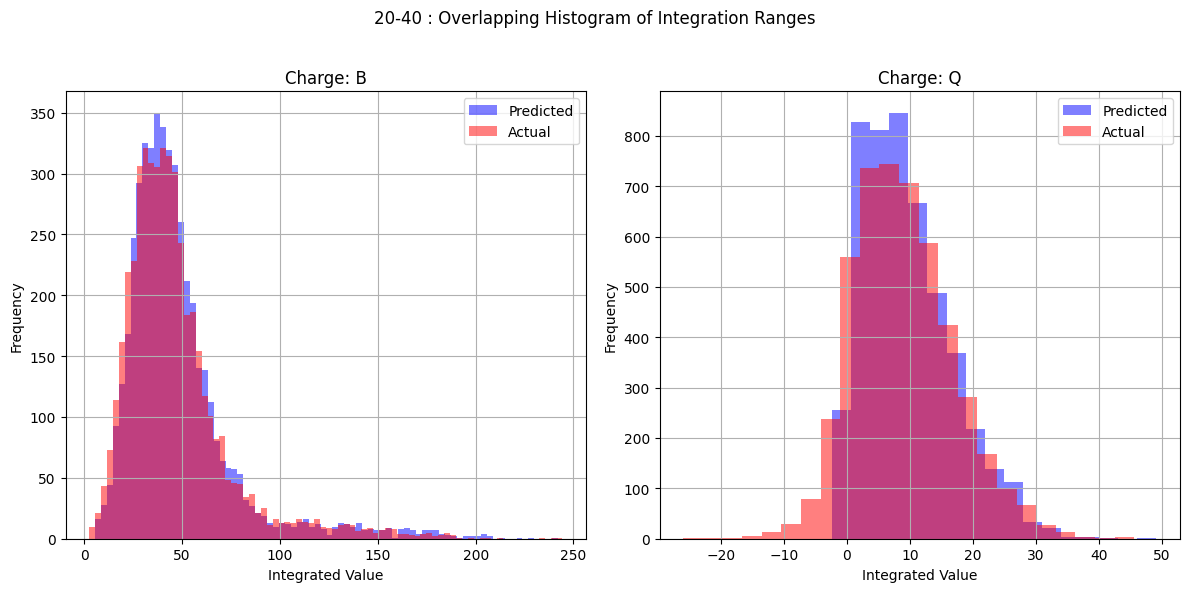

X_test: 38102
Check: 18820
0
actual 4764
pred 4764
1
actual 4684
pred 4684


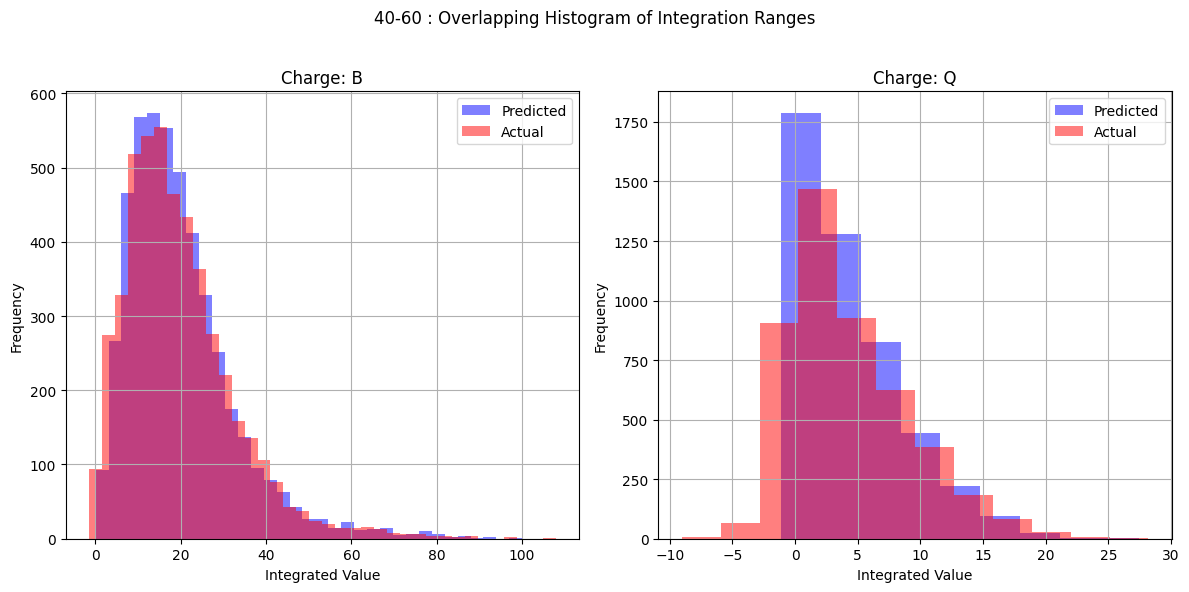

X_test: 38102
Check: 28268
0
actual 4852
pred 4852
1
actual 4982
pred 4982


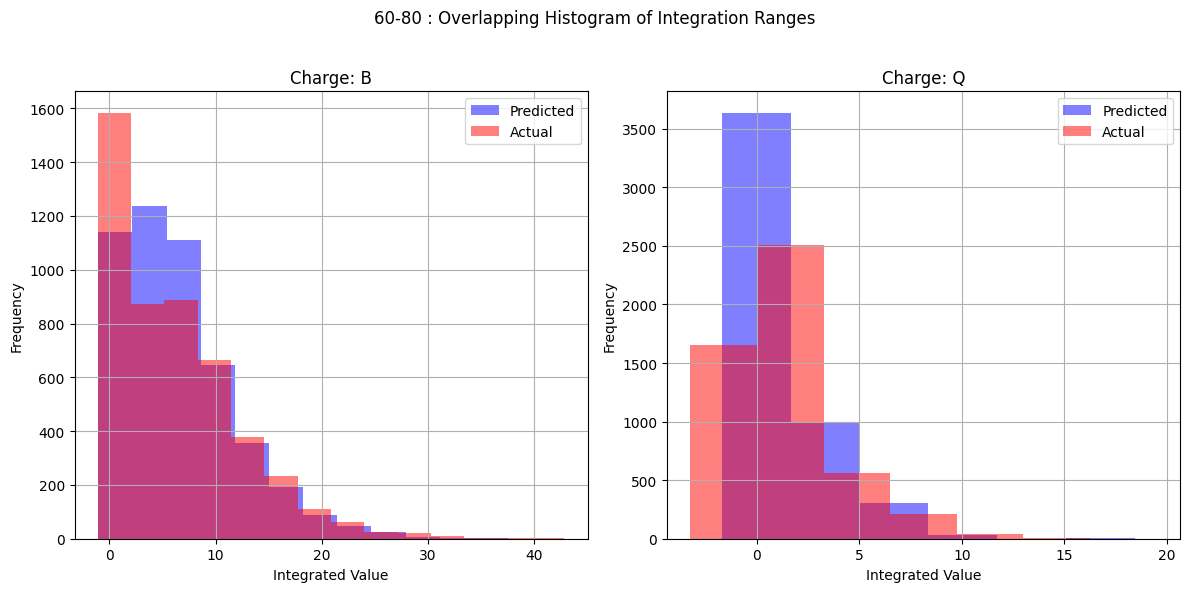

X_test: 38102
Check: 38102


In [28]:
plot_error_norm_nn(model_nn, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)
plot_histograms_nn(model_nn, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

# Transformer

SIMPLE

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor_2)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor_2)

# Create DataLoaders
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Transformer model for regression with Huber Loss
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=13, num_layers=6, dim_feedforward=1024, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(0) 
        x = self.transformer_encoder(x)
        x = x.squeeze(0)  
        x = self.dropout(x)
        x = self.linear(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor_2.shape[1]
model_tf = TransformerRegressor(input_dim, output_dim).to(device)

# Define the optimizer and Huber loss function
optimizer = optim.Adam(model_tf.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()  # Huber loss

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Training loop
epochs = 100
for epoch in range(epochs):
    model_tf.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input, b_labels = batch
        b_input = b_input.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()
        outputs = model_tf(b_input)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

    # Validation
    model_tf.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            b_input, b_labels = batch
            b_input = b_input.to(device)
            b_labels = b_labels.to(device)

            outputs = model_tf(b_input)
            loss = criterion(outputs, b_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")
    
    # Step with the scheduler
    scheduler.step(avg_val_loss)

# Final validation
model_tf.eval()
predictions, true_values = [], []

with torch.no_grad():
    for batch in val_dataloader:
        b_input, b_labels = batch
        b_input = b_input.to(device)
        b_labels = b_labels.to(device)

        outputs = model_tf(b_input)
        predictions.append(outputs.cpu().numpy())
        true_values.append(b_labels.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error: {mse}")

# Save the model
model_path = 'transformer_regressor.pth'
torch.save({
    'model_state_dict': model_tf.state_dict(),
    'input_dim': input_dim,
    'output_dim': output_dim
}, model_path)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 2.4258211255073547
Validation Loss: 1.9769991493225099
Epoch 2, Loss: 1.7530179167753899
Validation Loss: 1.4677668905258179
Epoch 3, Loss: 1.3477118633337468
Validation Loss: 1.1370683153470358
Epoch 4, Loss: 1.082269576971963
Validation Loss: 0.9163726162910462
Epoch 5, Loss: 0.8944056140096396
Validation Loss: 0.7552241738637289
Epoch 6, Loss: 0.7554430275555425
Validation Loss: 0.6349088339010874
Epoch 7, Loss: 0.6542521022110177
Validation Loss: 0.5473387110233306
Epoch 8, Loss: 0.5776837705165748
Validation Loss: 0.4718040180206299
Epoch 9, Loss: 0.5173194246404123
Validation Loss: 0.42114379088083903
Epoch 10, Loss: 0.47146647358500715
Validation Loss: 0.3781481166680654
Epoch 11, Loss: 0.4337744665825927
Validation Loss: 0.3456098049879074
Epoch 12, Loss: 0.4049935006855318
Validation Loss: 0.3189038360118866
Epoch 13, Loss: 0.3799359883438021
Validation Loss: 0.29347214301427205
Epoch 14, Loss: 0.35906796927420087
Validation Loss: 0.2754034272829692
Epoch 15, Lo

BEST TF


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.metrics import mean_squared_error

# Ensure using GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor_2)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor_2)

# Create DataLoaders
batch_size = 512
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Transformer model for regression with Huber Loss
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, nhead=26, num_layers=6, dim_feedforward=1024, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.batch_norm = nn.BatchNorm1d(input_dim)
        self.linear = nn.Linear(input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(0)
        x = self.transformer_encoder(x)
        x = x.squeeze(0)
        x = self.batch_norm(x)  # Apply batch normalization
        x = self.dropout(x)
        x = self.linear(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor_2.shape[1]
model_tf = TransformerRegressor(input_dim, output_dim).to(device)

# Define the optimizer and Huber loss function
optimizer = optim.AdamW(model_tf.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()  # Huber loss

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
early_stopping_patience = 15
best_val_loss = float('inf')
early_stopping_counter = 0

# Training loop
epochs = 150
for epoch in range(epochs):
    model_tf.train()
    total_loss = 0
    for batch in train_dataloader:
        b_input, b_labels = batch
        b_input = b_input.to(device)
        b_labels = b_labels.to(device)

        optimizer.zero_grad()
        outputs = model_tf(b_input)
        loss = criterion(outputs, b_labels)
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_tf.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch + 1}, Loss: {avg_train_loss}")

    # Validation
    model_tf.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_dataloader:
            b_input, b_labels = batch
            b_input = b_input.to(device)
            b_labels = b_labels.to(device)

            outputs = model_tf(b_input)
            loss = criterion(outputs, b_labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f"Validation Loss: {avg_val_loss}")
    
    # Step with the scheduler
    scheduler.step(avg_val_loss)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        early_stopping_counter = 0
        # Save the best model
        best_model_state = model_tf.state_dict()
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

# Load the best model state
model_tf.load_state_dict(best_model_state)

# Final validation
model_tf.eval()
predictions, true_values = [], []

with torch.no_grad():
    for batch in val_dataloader:
        b_input, b_labels = batch
        b_input = b_input.to(device)
        b_labels = b_labels.to(device)

        outputs = model_tf(b_input)
        predictions.append(outputs.cpu().numpy())
        true_values.append(b_labels.cpu().numpy())

predictions = np.concatenate(predictions, axis=0)
true_values = np.concatenate(true_values, axis=0)

mse = mean_squared_error(true_values, predictions)
print(f"Mean Squared Error: {mse}")

# Save the model
model_path = 'transformer_.pth'
torch.save({
    'model_state_dict': model_tf.state_dict(),
    'input_dim': input_dim,
    'output_dim': output_dim
}, model_path)


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Loss: 2.994244912326736
Validation Loss: 2.9322143522898356
Epoch 2, Loss: 2.8052675107981533
Validation Loss: 2.6168765354156496
Epoch 3, Loss: 2.4012047828443897
Validation Loss: 2.1376769797007245
Epoch 4, Loss: 1.8527893880069657
Validation Loss: 1.585331021944682
Epoch 5, Loss: 1.320585796096981
Validation Loss: 1.0548269073168437
Epoch 6, Loss: 0.8850023548475048
Validation Loss: 0.6244206849733989
Epoch 7, Loss: 0.596145522274427
Validation Loss: 0.3611757051944733
Epoch 8, Loss: 0.4424857124186202
Validation Loss: 0.2788892088333766
Epoch 9, Loss: 0.3683292124695426
Validation Loss: 0.20947700639565786
Epoch 10, Loss: 0.33129889533023704
Validation Loss: 0.19198515951633455
Epoch 11, Loss: 0.31014981535857156
Validation Loss: 0.15732149700323741
Epoch 12, Loss: 0.2903074580150963
Validation Loss: 0.14885812520980835
Epoch 13, Loss: 0.2830607948087206
Validation Loss: 0.13344173361857734
Epoch 14, Loss: 0.27506521664209815
Validation Loss: 0.13038022577762604
Epoch 15, 

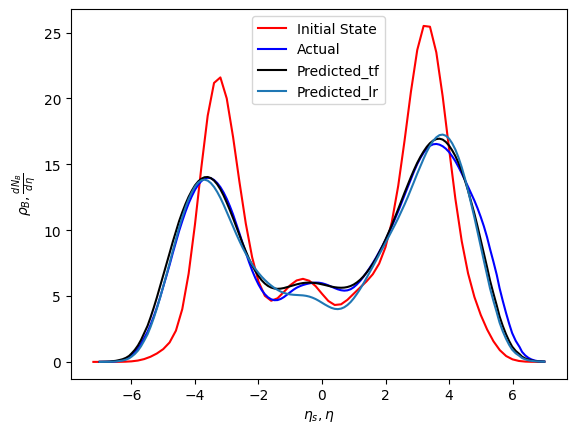

In [47]:
# Ensure the model is in evaluation mode
model_tf.eval()

# Extract a random sample from the test data
random_index = np.random.randint(0, X_test_tensor.shape[0])
X_sample = X_test_tensor[random_index].unsqueeze(0)  # Add batch dimension
y_actual = y_test_tensor[random_index].cpu().numpy()
y_actual_2 = y_test_tensor_2[random_index].cpu().numpy()
sigma = 1.5 # 4.5, 2, 2,5
y_smoothed = gaussian_filter1d(y_actual, sigma)

y_pred_lr = lr2.predict([X_test_1[random_index]])
# Make sure the sample is on the same device as the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_sample = X_sample.to(device)

# Make a prediction using the trained model
with torch.no_grad():
    y_pred_2 = model_tf(X_sample).cpu().numpy()
    y_pred_2 = gaussian_filter1d(y_pred_2, sigma)

# Assuming xaxes1 and xaxes2 are the same for all samples
# Update these based on your actual data if they vary
if X_sample[0, -3] == 0.0 and X_sample[0, -4] == 1.0:
    xaxes1 = Xin_Ru
    xaxes2 = Xfin_Ru
else:
    xaxes1 = Xin_Zr
    xaxes2 = Xfin_Zr
"""
initial = sum(X_sample.cpu().numpy()[0][:72])
final_pred = sum(y_pred_sample[0])
final_pred_lr = sum(y_pred_lr[0])
final_actual = sum(y_actual)
y_sm = sum(y_smoothed)

print('initial:',initial /71 * (max(xaxes1) - min(xaxes1)))
print('final_pred_tf: ', final_pred / 140 * (max(xaxes2) - min(xaxes2)))
print('final_pred_lr: ', final_pred_lr / 140 * (max(xaxes2) - min(xaxes2)))
print('final_actual: ',final_actual / 140 * (max(xaxes2) - min(xaxes2)))
print('final_smooth: ', y_sm / 140 * (max(xaxes2) - min(xaxes2)))
"""
# Plot the initial state, actual final state, and predicted final state
plt.plot(xaxes1, X_sample.cpu().numpy()[0][:72], 'r', label='Initial State')
plt.plot(xaxes2, y_actual, 'b', label='Actual')
#plt.plot(xaxes2, y_actual_2, 'b', label='Actual_smooth')
#plt.plot(xaxes2, y_smoothed, 'g', label='Actual_Smooth')
plt.plot(xaxes2,y_pred_2[0], 'k', label='Predicted_tf')
plt.plot(xaxes2, y_pred_lr[0], label='Predicted_lr')
plt.legend()
plt.xlabel(r'$\eta_s, \eta$')  # X-axis label with LaTeX formatting
plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')  # Y-axis label with LaTeX formatting
plt.show()

# EVALUATE ON AU

In [106]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Initialize lists to store Yin, Yfin, Xin, Xfin, Nuc, cent, and charge
all_Yin = []
all_Yfin = []
all_Xin = []
all_Xfin = []
all_Nuc = []
all_cent = []
all_charge = []
Dcts2 = []
Dcts2.append(Data3)
Dcts2.append(Data4)

for i, Data in enumerate(Dcts2):
    # Iterate through the dictionary
    for Nuc, cent_dict in Data.items():
        for cent, charge_dict in cent_dict.items():
            if isinstance(charge_dict, dict):
                for charge, data_dict in charge_dict.items():
                    if isinstance(data_dict, dict) and "INITIAL" in data_dict and "FINAL" in data_dict:
                        # Load Xin, Yin, Xfin, Yfin using the load function
                        Xin, Yin, Xfin, Yfin = load(Data, Nuc, cent, charge)
                        
                        # Add 200 to each array in Yin
                        if i == 1:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 200)))
                        else:
                            Yin = np.hstack((Yin, np.full((Yin.shape[0], 1), 19)))
                        
                        # Append to the lists along with identifiers
                        all_Yin.append(Yin)
                        all_Yfin.append(Yfin)
                        all_Xin.append(Xin)
                        all_Xfin.append(Xfin)
                        all_Nuc.extend([Nuc] * Yin.shape[0])  # Extend with Nuc for each sample
                        all_cent.extend([cent] * Yin.shape[0])  # Extend with cent for each sample
                        all_charge.extend([charge] * Yin.shape[0])  # Extend with charge for each sample

# Convert lists to numpy arrays
all_Yin_full = np.concatenate(all_Yin, axis=0)  # Assuming concatenation is appropriate
all_Yfin_full = np.concatenate(all_Yfin, axis=0)
all_Nuc_full = np.array(all_Nuc)
all_cent_full = np.array(all_cent)
all_charge_full = np.array(all_charge)

# Now all_Yin, all_Yfin, all_Xin, all_Xfin, all_Nuc, all_cent, and all_charge contain all your data
print("Shape of all_Yin:", all_Yin_full.shape)
print("Shape of all_Yfin:", all_Yfin_full.shape)
print("Shape of all_Nuc:", all_Nuc_full.shape)
print("Shape of all_cent:", all_cent_full.shape)
print("Shape of all_charge:", all_charge_full.shape)

# Encode categorical variables
nuc_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_Nuc_encoded_full = nuc_one_hot_encoder.fit_transform(all_Nuc_full.reshape(-1, 1))
charge_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_charge_encoded_full = charge_one_hot_encoder.fit_transform(all_charge_full.reshape(-1, 1))
cent_one_hot_encoder = OneHotEncoder(sparse_output=False)
all_cent_encoded_full = cent_one_hot_encoder.fit_transform(all_cent_full.reshape(-1, 1))

# Create au_encoded with the same shape as all_Nuc_encoded_full
au_encoded = np.tile([1.0, 0.0, 0.0], (all_Nuc_encoded_full.shape[0], 1))

# Concatenate features
X_features = np.concatenate([all_Yin_full, au_encoded, all_charge_encoded_full], axis=1)

# Split data into training and testing sets
X_train_1, X_test_1, y_train_1, y_test_1, all_cent_train_1, all_cent_test_1, all_charge_train_1, all_charge_test_1 = train_test_split(
    X_features, all_Yfin_full, all_cent_encoded_full, all_charge_encoded_full, test_size=0.2, random_state=42, shuffle=True)

# Print some details for verification
print("Shape of X_train:", X_train_1.shape)
print("Shape of X_test:", X_test_1.shape)
print("Shape of y_train:", y_train_1.shape)
print("Shape of y_test:", y_test_1.shape)
print("Shape of all_cent_train:", all_cent_train_1.shape)
print("Shape of all_cent_test:", all_cent_test_1.shape)
print("Shape of all_charge_train:", all_charge_train_1.shape)
print("Shape of all_charge_test:", all_charge_test_1.shape)

# Print mappings of the encoders
print("\nNuc encoder mapping:")
for i, category in enumerate(nuc_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {nuc_one_hot_encoder.transform([[category]])[0]}")

print("\nCharge encoder mapping:")
for i, category in enumerate(charge_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {charge_one_hot_encoder.transform([[category]])[0]}")

print("\nCent encoder mapping:")
for i, category in enumerate(cent_one_hot_encoder.categories_[0]):
    print(f"{category} -> {i} -> {cent_one_hot_encoder.transform([[category]])[0]}")


Shape of all_Yin: (31918, 73)
Shape of all_Yfin: (31918, 141)
Shape of all_Nuc: (31918,)
Shape of all_cent: (31918,)
Shape of all_charge: (31918,)
Shape of X_train: (25534, 78)
Shape of X_test: (6384, 78)
Shape of y_train: (25534, 141)
Shape of y_test: (6384, 141)
Shape of all_cent_train: (25534, 5)
Shape of all_cent_test: (6384, 5)
Shape of all_charge_train: (25534, 2)
Shape of all_charge_test: (6384, 2)

Nuc encoder mapping:
Au -> 0 -> [1.]

Charge encoder mapping:
B -> 0 -> [1. 0.]
Q -> 1 -> [0. 1.]

Cent encoder mapping:
0-10 -> 0 -> [1. 0. 0. 0. 0.]
10-20 -> 1 -> [0. 1. 0. 0. 0.]
20-40 -> 2 -> [0. 0. 1. 0. 0.]
40-60 -> 3 -> [0. 0. 0. 1. 0.]
60-80 -> 4 -> [0. 0. 0. 0. 1.]


In [109]:

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors and move to the device
X_train_tensor = torch.FloatTensor(X_train_1).to(device)
y_train_tensor = torch.FloatTensor(y_train_1).to(device)
X_test_tensor = torch.FloatTensor(X_test_1).to(device)
y_test_tensor = torch.FloatTensor(y_test_1).to(device)

y_train_tensor_2 = torch.FloatTensor(y_train_2).to(device)
y_test_tensor_2 = torch.FloatTensor(y_test_2).to(device)

In [108]:
y_train_2 = []
y_test_2 = []
sigma = 3
threshold = len(y_train_1) / 2

for y  in y_train_1:
    y_smoothed = gaussian_filter1d(y, sigma)
    if threshold > 0:
        y_train_2.append(y_smoothed)
    else:
        y_train_2.append(y)
    #threshold -= 1

threshold = len(y_test_1) / 2
for y in y_test_1:
    y_smoothed = gaussian_filter1d(y, sigma)
    if threshold > 0:
        y_test_2.append(y_smoothed)
    else:
        y_test_2.append(y)
    #threshold -= 1
    


1336.710010169074
initial: 187.99986795281075
final_pred:  132.08754788704536
final_actual:  133.6710010169074


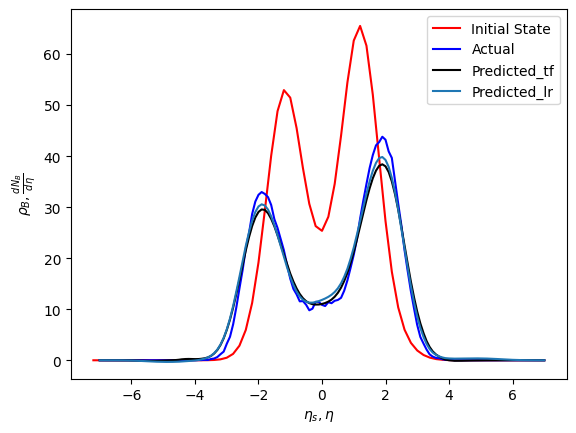

In [133]:
# Ensure the model is in evaluation mode
model_tf.eval()

# Extract a random sample from the test data
random_index = np.random.randint(0, X_train_tensor.shape[0])
X_sample = X_train_tensor[random_index].unsqueeze(0)  # Add batch dimension
y_actual = y_train_tensor[random_index].cpu().numpy()
y_actual_2 = y_train_tensor_2[random_index].cpu().numpy()
sigma = 1.5 # 4.5, 2, 2,5
y_smoothed = gaussian_filter1d(y_actual, sigma)

if X_train_1[random_index][-2] == 1.0 and X_train_1[random_index][-1] == 0.0:
    y_pred_lr = lr2.predict([X_train_1[random_index]])
    # Make sure the sample is on the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_sample = X_sample.to(device)

    # Make a prediction using the trained model
    with torch.no_grad():
        y_pred_2 = model_tf(X_sample).cpu().numpy()
        y_pred_2 = gaussian_filter1d(y_pred_2, sigma)

    # Assuming xaxes1 and xaxes2 are the same for all samples
    # Update these based on your actual data if they vary

    xaxes1 = Xin_Au
    xaxes2 = Xfin_Au
    """
    initial = sum(X_sample.cpu().numpy()[0][:72])
    final_pred = sum(y_pred_sample[0])
    final_pred_lr = sum(y_pred_lr[0])
    final_actual = sum(y_actual)
    y_sm = sum(y_smoothed)

    print('initial:',initial /71 * (max(xaxes1) - min(xaxes1)))
    print('final_pred_tf: ', final_pred / 140 * (max(xaxes2) - min(xaxes2)))
    print('final_pred_lr: ', final_pred_lr / 140 * (max(xaxes2) - min(xaxes2)))
    print('final_actual: ',final_actual / 140 * (max(xaxes2) - min(xaxes2)))
    print('final_smooth: ', y_sm / 140 * (max(xaxes2) - min(xaxes2)))
    """

    initial = sum(X_train_1[random_index][:72])
    final_pred = sum(y_pred_2[0])
    final_actual = sum(y_train_1[random_index])
    #print(final_actual)
    #print(len(y2_pred))


    # Save current plot to the PdfPages object
    #pdf_pages.savefig()
    plt.show()

    print('initial:',initial /71 * (max(xaxes1) - min(xaxes1)))
    print('final_pred: ', final_pred / 140 * (max(xaxes2) - min(xaxes2)))
    print('final_actual: ',final_actual / 140 * (max(xaxes2) - min(xaxes2)))

    # Plot the initial state, actual final state, and predicted final state
    plt.plot(xaxes1, X_sample.cpu().numpy()[0][:72], 'r', label='Initial State')
    plt.plot(xaxes2, y_actual, 'b', label='Actual')
    #plt.plot(xaxes2, y_actual_2, 'b', label='Actual_smooth')
    #plt.plot(xaxes2, y_smoothed, 'g', label='Actual_Smooth')
    plt.plot(xaxes2,y_pred_2[0], 'k', label='Predicted_tf')
    plt.plot(xaxes2, y_pred_lr[0], label='Predicted_lr')
    plt.legend()
    plt.xlabel(r'$\eta_s, \eta$')  # X-axis label with LaTeX formatting
    plt.ylabel(r'$\rho_B, \frac{dN_B}{d\eta}$')  # Y-axis label with LaTeX formatting
    plt.show()

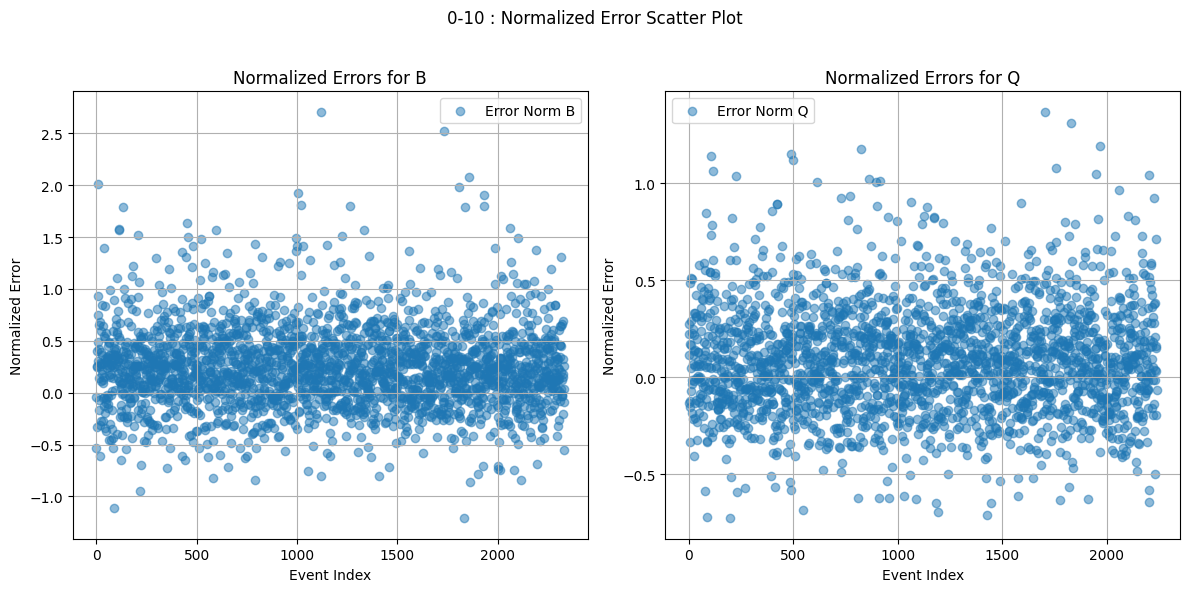

X_test: 38102
Check: 4571
Total >1 std dev: 106


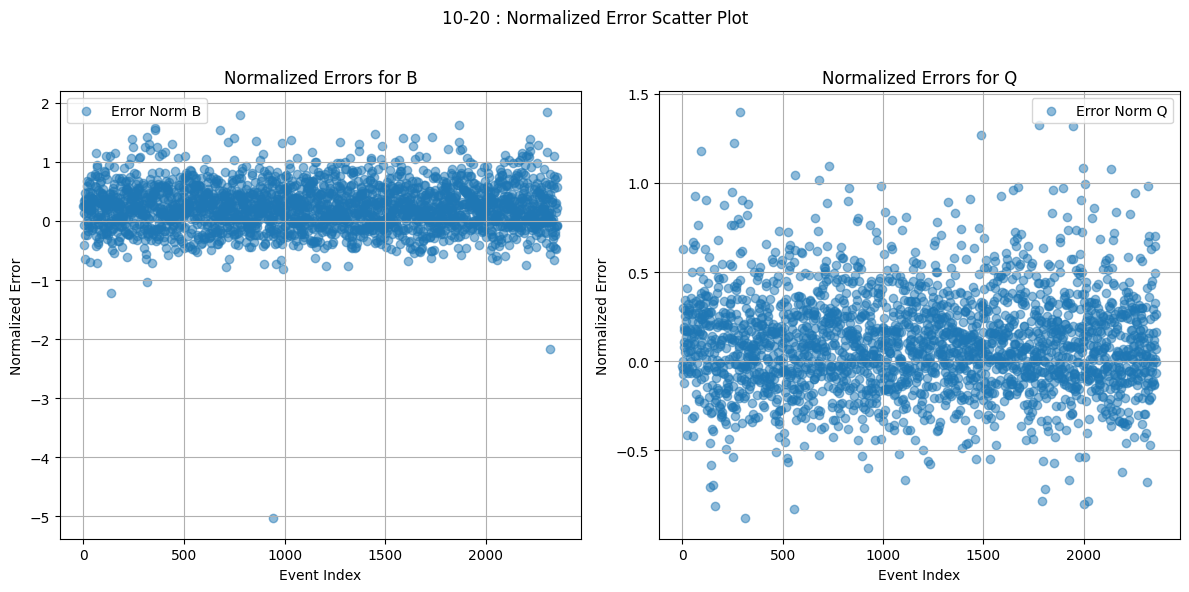

X_test: 38102
Check: 9293
Total >1 std dev: 91


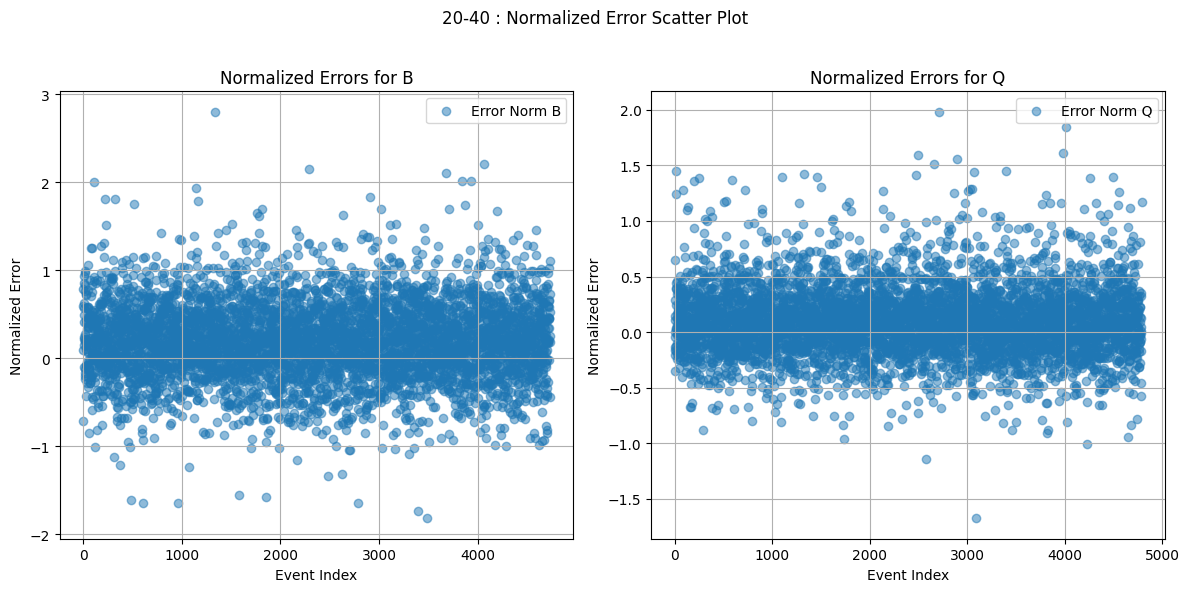

X_test: 38102
Check: 18820
Total >1 std dev: 256


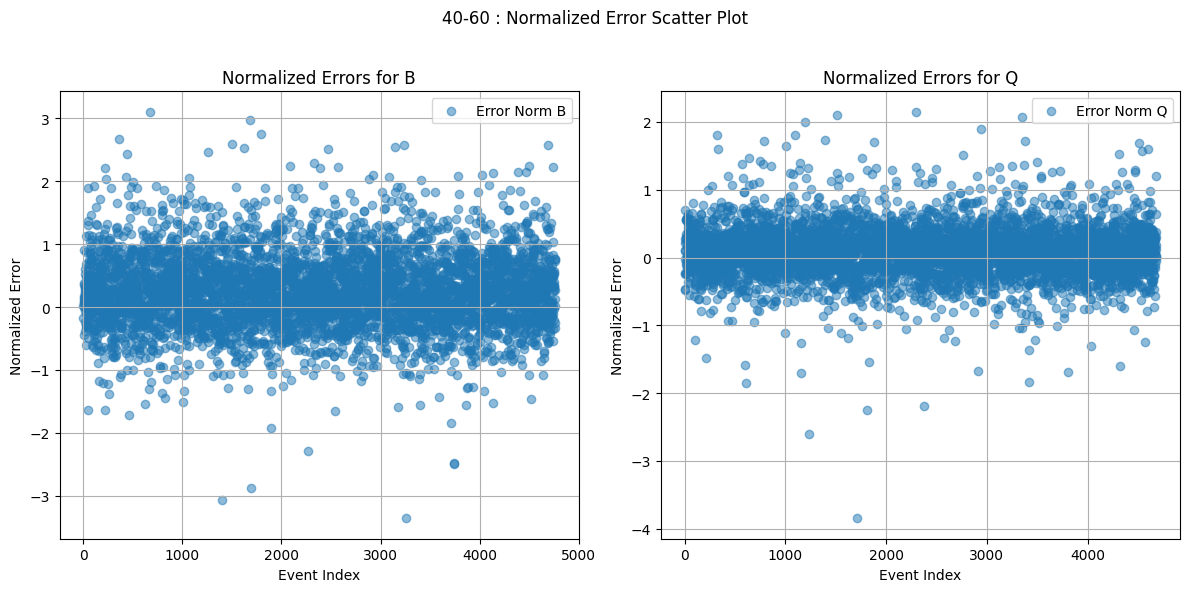

X_test: 38102
Check: 28268
Total >1 std dev: 621


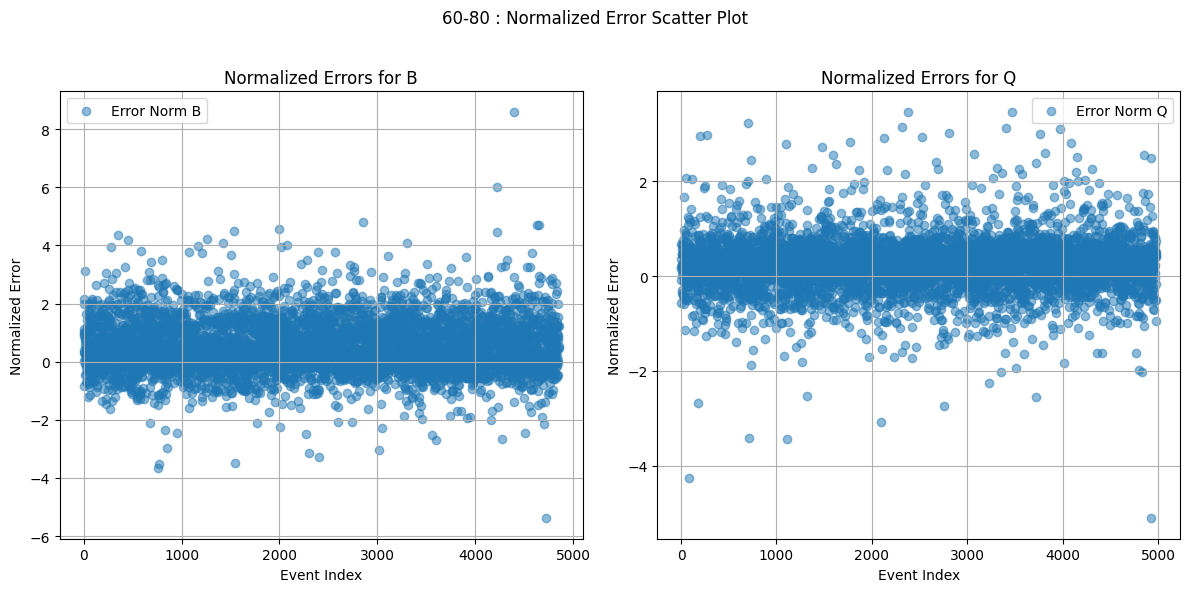

X_test: 38102
Check: 38102
Total >1 std dev: 1863
Total >1 std dev: 5284
0
actual 2332
pred 2332
1
actual 2239
pred 2239


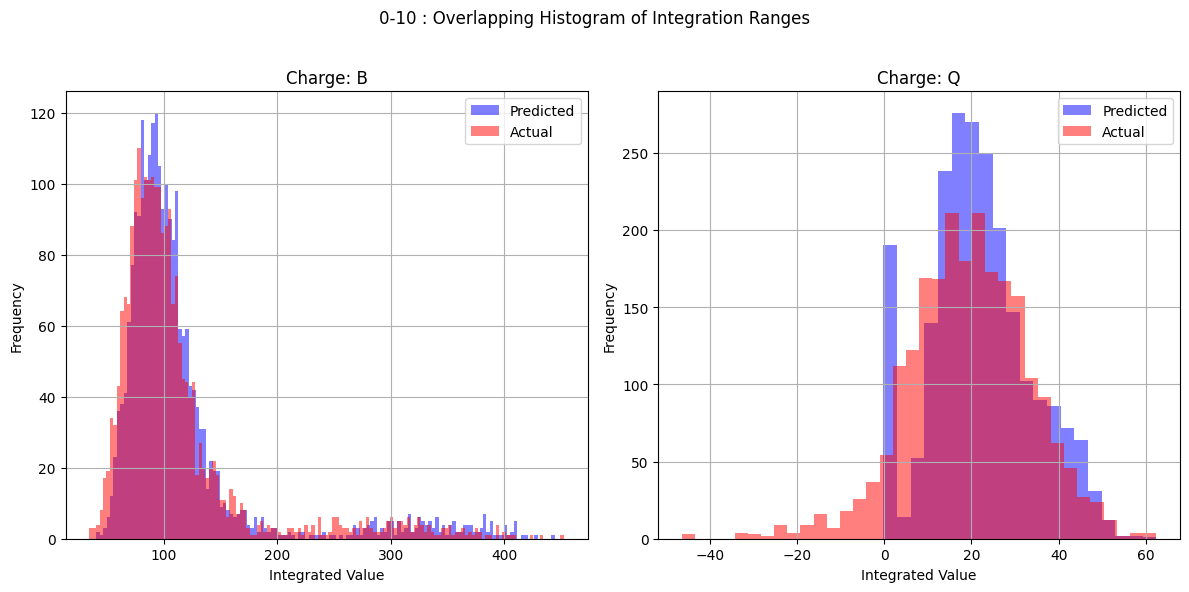

X_test: 38102
Check: 4571
0
actual 2358
pred 2358
1
actual 2364
pred 2364


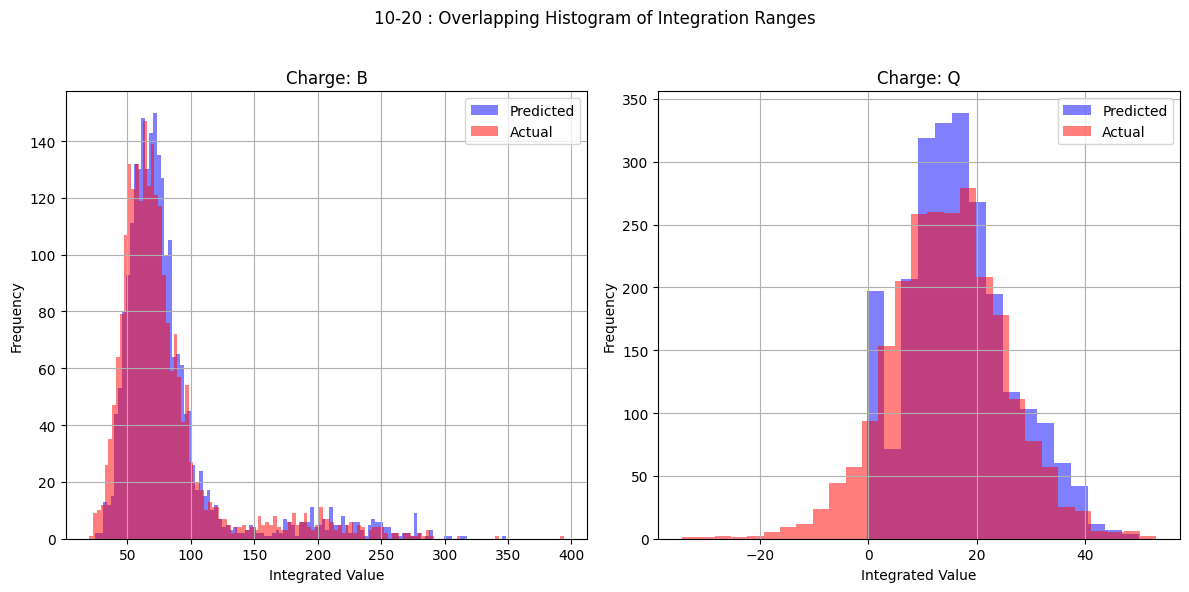

X_test: 38102
Check: 9293
0
actual 4736
pred 4736
1
actual 4791
pred 4791


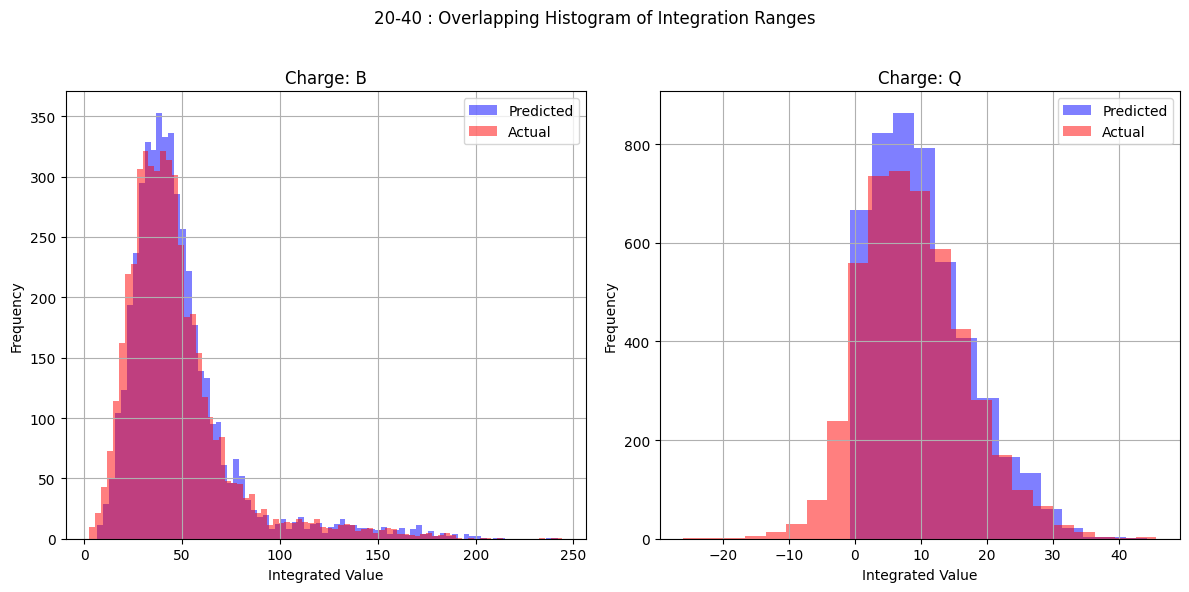

X_test: 38102
Check: 18820
0
actual 4764
pred 4764
1
actual 4684
pred 4684


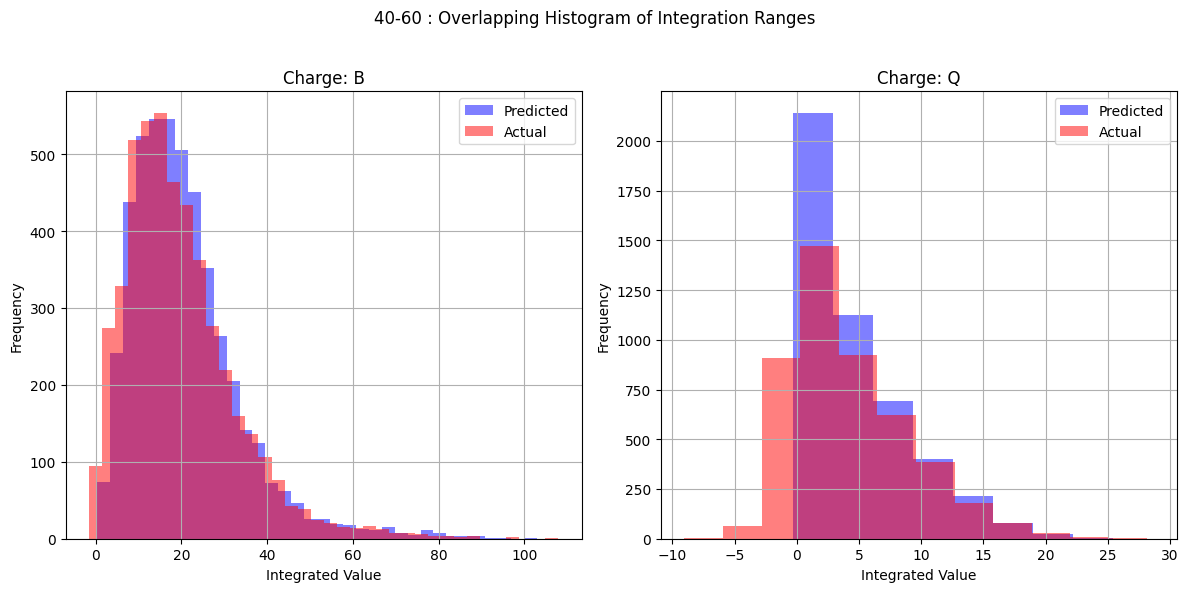

X_test: 38102
Check: 28268
0
actual 4852
pred 4852
1
actual 4982
pred 4982


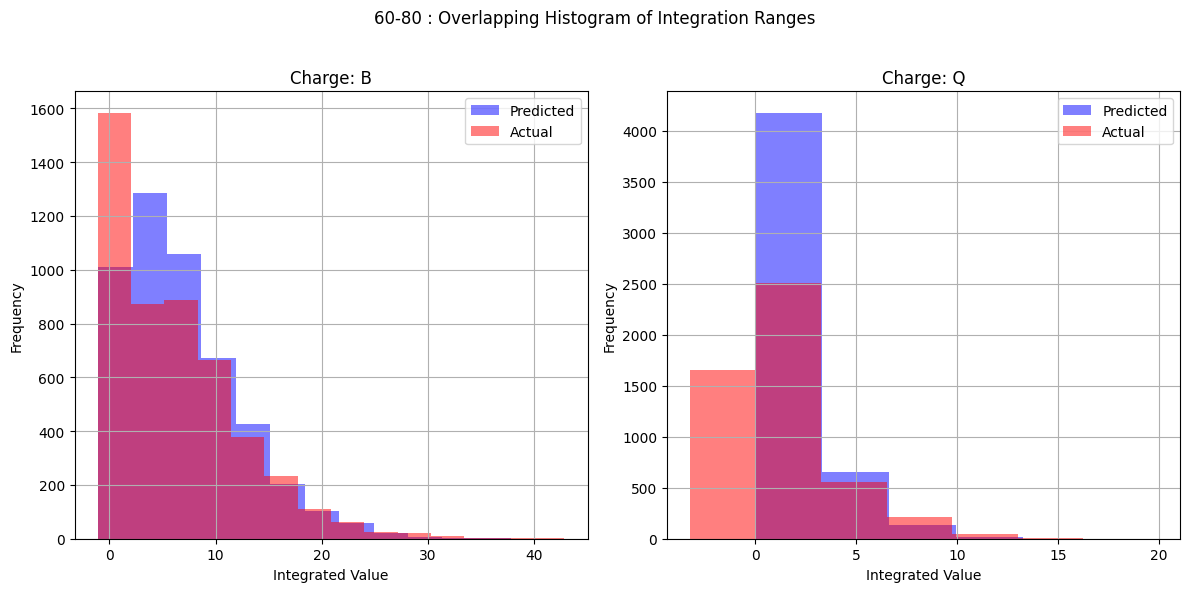

X_test: 38102
Check: 38102


In [32]:
plot_error_norm_nn(model_tf, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)
plot_histograms_nn(model_tf, X_test_1, y_test_1, all_cent_test_1, all_charge_test_1)

In [33]:
model_path = 'transformer_regressor_2.pth'

# Save model with state dictionary and other necessary information
torch.save({
    'input_dim': input_dim,
    'output_dim': output_dim,
    'model_state_dict': model_tf.state_dict()
}, model_path)


# RESULTS:

Model  / Points beyond 1st std dev

LR     1735

MLP    1705

NN     1668

NN2    1481

TF     3168


# 2 SCALED Y

In [34]:
# Create a StandardScaler instance for X and y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [35]:
def finetune2(model, X_train, y_train, X_test, y_test, flag=False, scale=True):
    start_time = time.time()
    
    if scale == True:
        # Fit the scaler to the 'all_Yin' feature in the training data and transform it
        all_Yin_train_scaled = scaler_X.fit_transform(X_train[:, :72]) 

        # Use the same scaler to transform the 'all_Yin' feature in the test data
        all_Yin_test_scaled = scaler_X.transform(X_test[:, :72])  

        # Concatenate scaled 'all_Yin' with the encoded categorical features
        X_train = np.concatenate([all_Yin_train_scaled, X_train[:, 72:]], axis=1)
        X_test = np.concatenate([all_Yin_test_scaled, X_test[:, 72:]], axis=1)

        # Scale y_train and y_test
        y_train = scaler_y.fit_transform(y_train)
        y_test = scaler_y.transform(y_test)

    if flag:
        # Train the model using only the first 72 features
        model.fit(X_train[:, :72], y_train)
        # Predict on test data using only the first 72 features
        y_pred = model.predict(X_test[:, :72])
    else:
        # Train the model on all features

        model.fit(X_train, y_train)
        # Predict on test data using all features
        y_pred = model.predict(X_test)
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds.")

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    #
    sample_index = np.random.randint(1, len(X_test))
    y1_plot = scaler_X.inverse_transform(X_test[sample_index, :72].reshape(1, -1))  # First 72 features are all_Yin
    y1 = X_test[sample_index]
    y2 = scaler_y.inverse_transform([y_test[sample_index]])  # Corresponding y_test value
    #y2 = y2.flatten()

    if y1[-3] == 0.0 and y1[-4] == 1.0:
        xaxes1 = Xin_Ru
        xaxes2 = Xfin_Ru
        #print('Ru')
    else:
        xaxes1 = Xin_Zr
        xaxes2 = Xfin_Zr
        #print('Zr')
    #print(xaxes1, xaxes2)
    if flag:
        y1 = y1[:72]
        y2_pred = model.predict([y1])
    else:
        y2_pred = model.predict([y1])

    # Inverse transform the predictions
    # Inverse transform the predictions
    #y2_pred = [y2_pred]
    y2_pred = scaler_y.inverse_transform(y2_pred)


    # Plotting
    plt.plot(xaxes1, y1_plot[0], 'r', label='Initial')
    plt.plot(xaxes2, y2[0], 'b', label='Final')
    plt.plot(xaxes2, y2_pred[0], 'k', label='Predicted')
    plt.legend()
    plt.xlabel('X-axis label')  # Replace with your actual x-axis label
    plt.ylabel('Y-axis label')  # Replace with your actual y-axis label
    plt.show()
    return model, X_test, y_test


In [36]:
# Define your model
# lr2 = LinearRegression()
verbose = True

# Plotting function for histograms
def plot_histograms2(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels

    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)

    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Overlapping Histogram of Integration Ranges')

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            integration_range_pred = []
            integration_range_actual = []
            integration_range_initial = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):
                y1 = cent_Yin[k]
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]
                y2_pred_scaled = model.predict([y1])

                # Scale the predictions back to the original scale
                y2_pred = scaler_y.inverse_transform(y2_pred_scaled)
                y2 = scaler_y.inverse_transform(np.array([y2]).reshape(1, -1)) 
                # Flatten y2 to a 1D array
                y2 = y2.flatten()


                # Sum the corresponding values in y2_pred
                integrated_value_pred = np.sum(y2_pred[0][indices])
                integration_range_pred.append(integrated_value_pred)

                integrated_value_actual = np.sum(y2[indices])
                integration_range_actual.append(integrated_value_actual)

                integrated_value_initial = np.sum(y1[indices2])
                integration_range_initial.append(integrated_value_initial)
                verbose = True
                """
                if verbose == True and k == 10:
                # Plotting the graph as before
                    plt.plot(Xin_Ru, y1[:72], 'r')
                    plt.plot(Xfin_Ru, y2, 'b')
                    plt.plot(Xfin_Ru, y2_pred[0], 'k')
                    plt.plot(Xfin_Ru[indices], y2_pred[0][indices], 'g', linewidth = 5, alpha = 0.5) 
                    plt.legend(['Initial', 'Final', 'Predicted', 'Range'])
                    plt.show()
                    verbose = False
                """
            # Calculate moments and cumulants
            moments_pred, cumulants_pred = calculate_moments_cumulants(integration_range_pred)
            moments_actual, cumulants_actual = calculate_moments_cumulants(integration_range_actual)
            """
            print(f'{cent_range} : Moments for {charge_type} Predicted')
            print(moments_pred)
            print(f'{cent_range} : Moments for {charge_type} Actual')
            print(moments_actual)

            print(f'{cent_range} : Cumulants for {charge_type} Predicted')
            print(cumulants_pred)
            print(f'{cent_range} : Cumulants for {charge_type} Actual')
            """
            # Calculate the range of your data
            data_range_pred = max(integration_range_pred) - min(integration_range_pred)
            data_range_actual = max(integration_range_actual) - min(integration_range_actual)

            # Calculate the number of bins of width 0.5 within your data range
            num_bins_pred = int(data_range_pred / 3)
            num_bins_actual = int(data_range_actual / 3)

            plt.subplot(1, 2, i + 1)
            print(i)
            plt.hist(integration_range_pred, bins=num_bins_pred, color='b', alpha=0.5, label='Predicted')
            plt.hist(integration_range_actual, bins=num_bins_actual, color='r', alpha=0.5, label='Actual')
            plt.title(f'Charge: {charge_type}')
            plt.xlabel('Integrated Value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True)

            print("actual", len(integration_range_actual))
            print("pred", len(integration_range_pred))

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)


In [37]:
# Plotting function for error norm scatter plots
def plot_error_norm2(model, X_test, y_test, all_cent_test, all_charge_test, flag=False):
    # Charge labels
    charge_labels = ['B', 'Q']
    check = 0
    error_count = 0
    # Centrality ranges
    cent_ranges = ['0-10', '10-20', '20-40', '40-60', '60-80']

    # Decode one-hot encoded centrality and charge labels
    all_cent_test_decoded = cent_one_hot_encoder.inverse_transform(all_cent_test)
    all_charge_test_decoded = charge_one_hot_encoder.inverse_transform(all_charge_test)

    for cent_range in cent_ranges:
        plt.figure(figsize=(12, 6))
        plt.suptitle(f'{cent_range} : Normalized Error Scatter Plot')
        error_count_cent = 0

        for i, charge_type in enumerate(charge_labels):
            cent_Yin = []
            cent_Yfin = []

            # Iterate through the test data
            for j in range(X_test.shape[0]):
                Yin = X_test[j]
                Yfin = y_test[j]

                # Extract decoded values
                cent_decoded = all_cent_test_decoded[j][0]
                charge_decoded = all_charge_test_decoded[j][0]

                # Check if the current sample belongs to the current centrality range and charge type
                if (cent_decoded == cent_range) and (charge_decoded == charge_type):
                    cent_Yin.append(Yin)
                    cent_Yfin.append(Yfin)

            if not cent_Yin or not cent_Yfin:
                continue

            cent_Yin = np.array(cent_Yin)
            cent_Yfin = np.array(cent_Yfin)

            x_range_min = -0.8
            x_range_max = 0.8

            # Find indices where x-axis values are within the specified range
            indices = np.where((Xfin_Ru >= x_range_min) & (Xfin_Ru <= x_range_max))[0]
            indices2 = np.where((Xin_Ru >= x_range_min) & (Xin_Ru <= x_range_max))[0]
            std_dev_actual = []
            error_norm = []

            check += len(cent_Yin)
            for k in range(len(cent_Yin)):#iterating the test data
                y1 = cent_Yin[k]#one event in the test data
                if flag:
                    y1 = y1[:72]
                y2 = cent_Yfin[k]#actual final state of the event
                y2 = scaler_y.inverse_transform(y2.reshape(1, -1))
                y2_pred = model.predict([y1])#predicted final state of the event
                y2_pred = scaler_y.inverse_transform(y2_pred.reshape(1, -1))
                y2 = y2.flatten()

                integrated_value_pred = np.sum(y2_pred[0][indices]) / len(y2_pred[0][indices])#sum of preds
                integrated_value_actual = np.sum(y2[indices])/len(y2_pred[0][indices])#sum of actual
                std_dev = np.std(y2[indices])
                std_dev_actual.append(std_dev)#std of actual
                error = (integrated_value_pred - integrated_value_actual) / std_dev#error
                error_norm.append(error)#list of errors for all the events
                
                if abs(error) > 1:
                    error_count_cent += 1

                verbose = True

            # Scatter plot for normalized errors
            plt.subplot(1, 2, i + 1)
            plt.scatter(range(len(error_norm)), error_norm, alpha=0.5, label=f'Error Norm {charge_type}')
            plt.title(f'Normalized Errors for {charge_type}')
            plt.xlabel('Event Index')
            plt.ylabel('Normalized Error')
            plt.legend()
            plt.grid(True)
            error_count += error_count_cent

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        print("X_test:", len(X_test))
        print("Check:", check)
        print("Total >1 std dev:", error_count_cent)
    print("Total >1 std dev:", error_count)

# Example usage of the function
# Assuming cent_one_hot_encoder, charge_one_hot_encoder, X_test, y_test, all_cent_test, and all_charge_test are defined
#plot_error_norm(lr2, X_test, y_test, all_cent_test, all_charge_test)

#plot_error_norm2(lr_scaled, X_t, y_t, all_cent_test_1, all_charge_test_1)



Training completed in 2.32 seconds.
Mean Squared Error: 0.21820836192801799


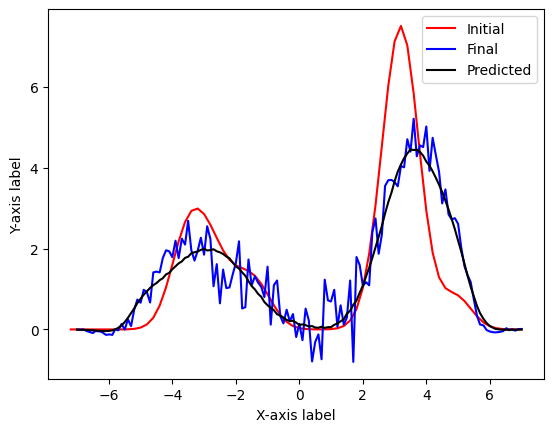

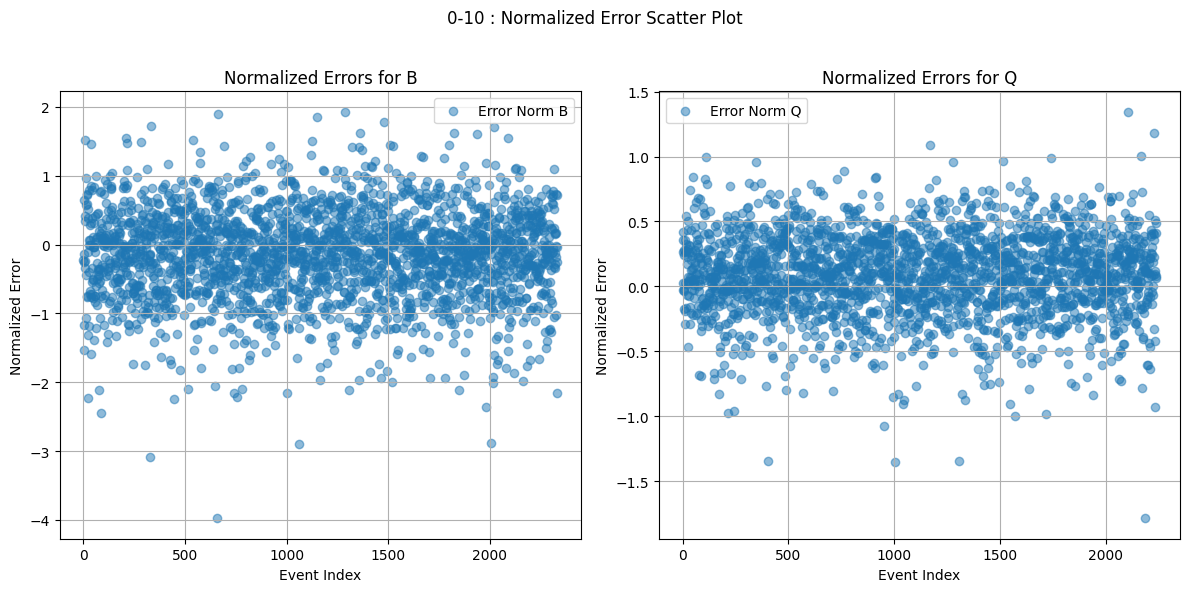

X_test: 38102
Check: 4571
Total >1 std dev: 284


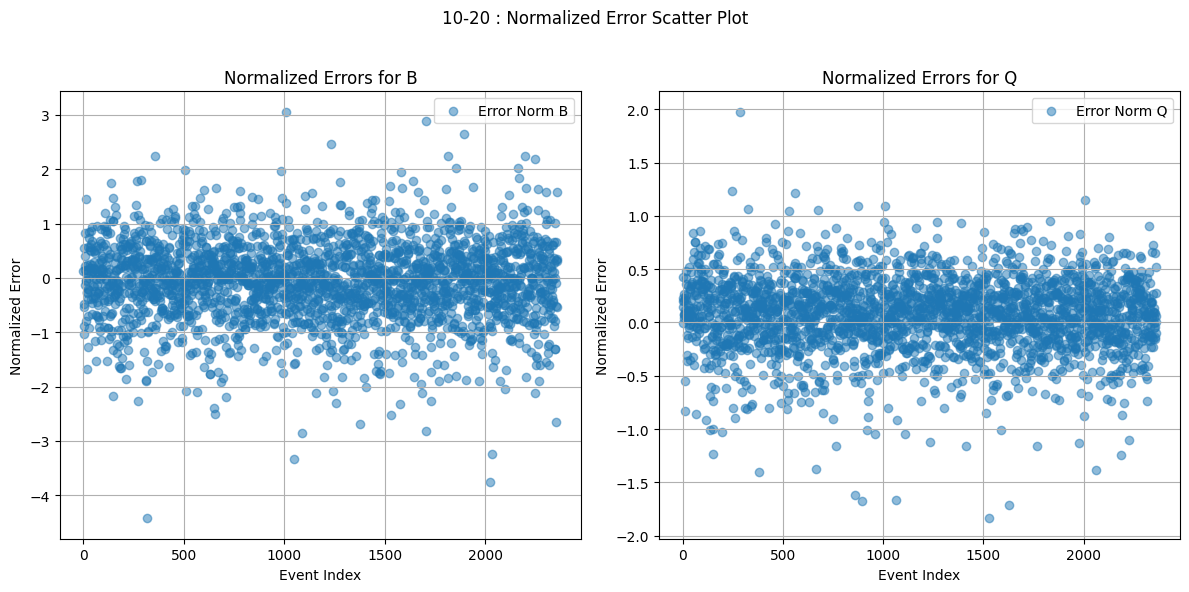

X_test: 38102
Check: 9293
Total >1 std dev: 371


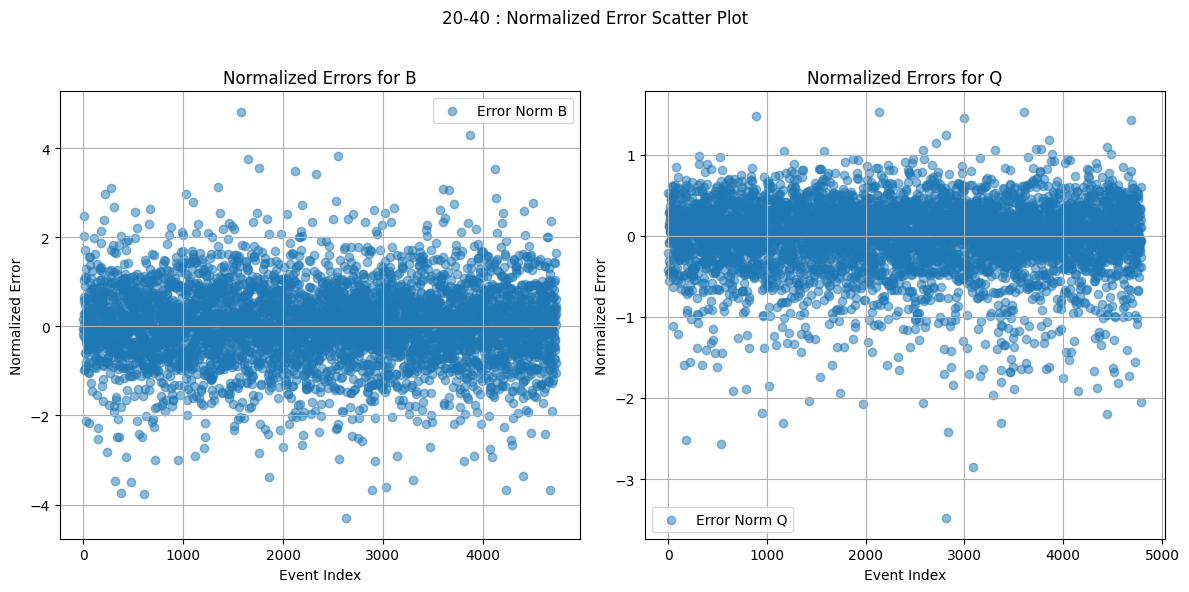

X_test: 38102
Check: 18820
Total >1 std dev: 1151


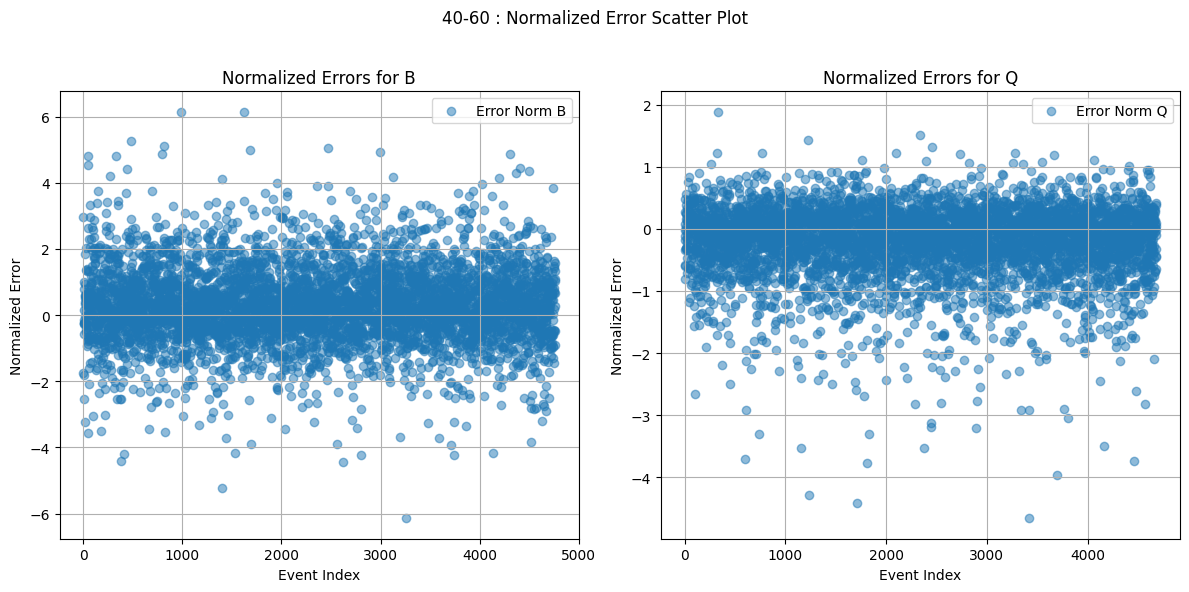

X_test: 38102
Check: 28268
Total >1 std dev: 1964


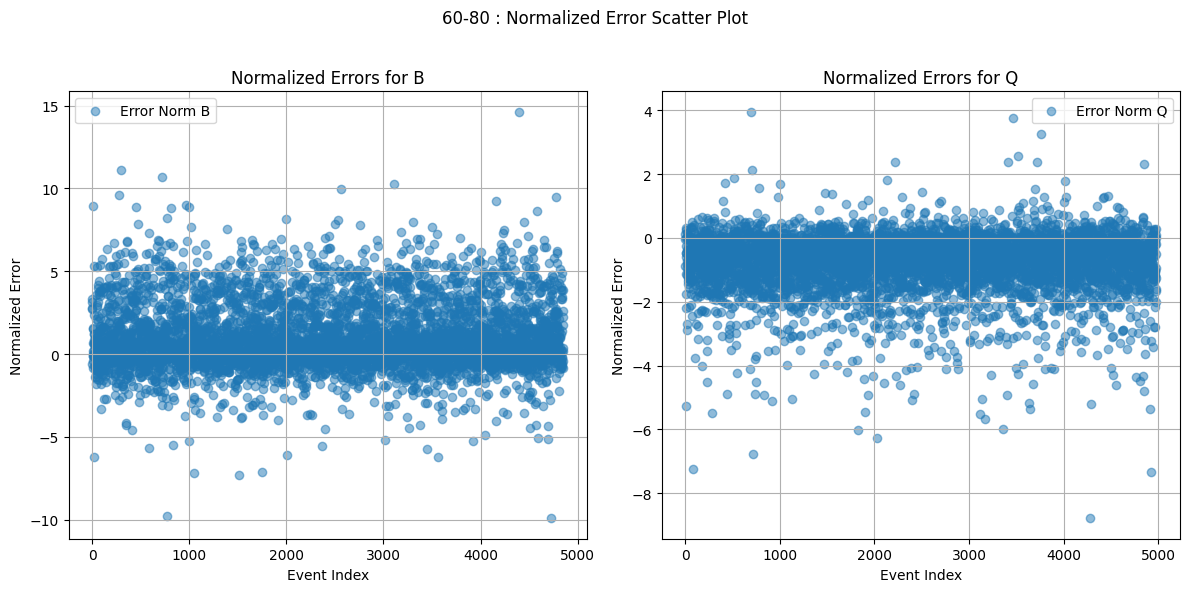

X_test: 38102
Check: 38102
Total >1 std dev: 3998
Total >1 std dev: 13279
0
actual 2332
pred 2332
1
actual 2239
pred 2239


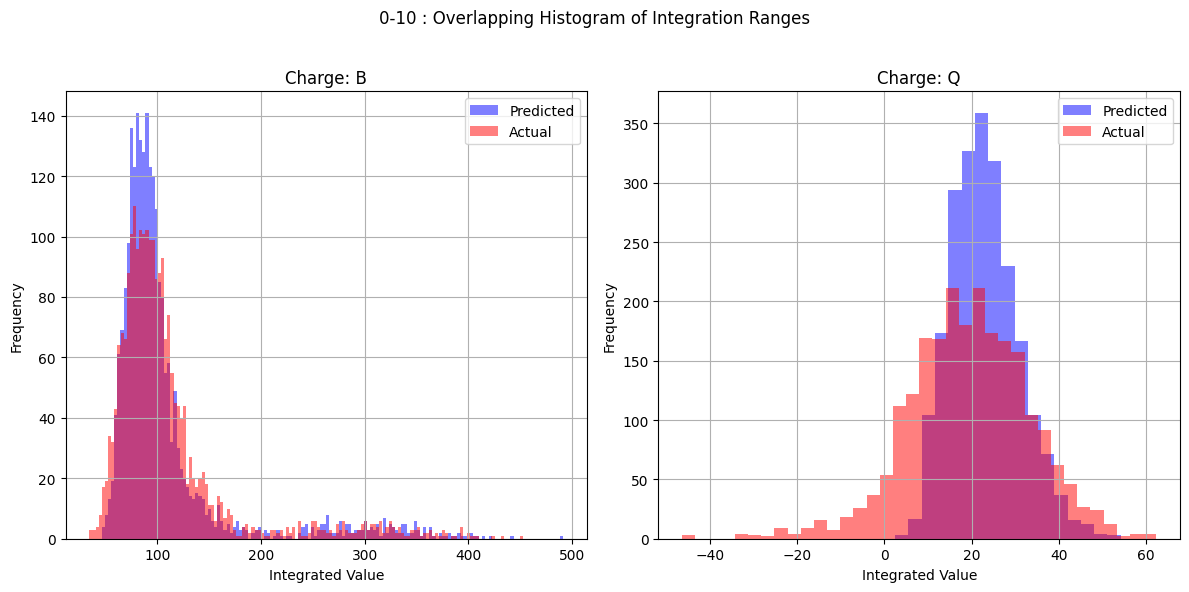

X_test: 38102
Check: 4571
0
actual 2358
pred 2358
1
actual 2364
pred 2364


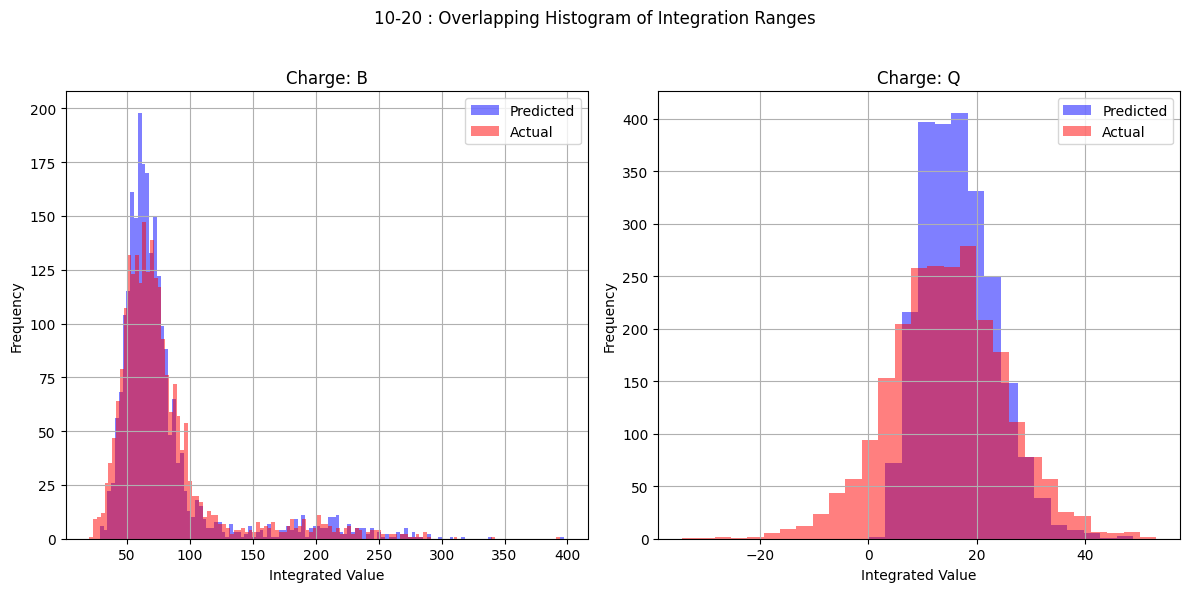

X_test: 38102
Check: 9293
0
actual 4736
pred 4736
1
actual 4791
pred 4791


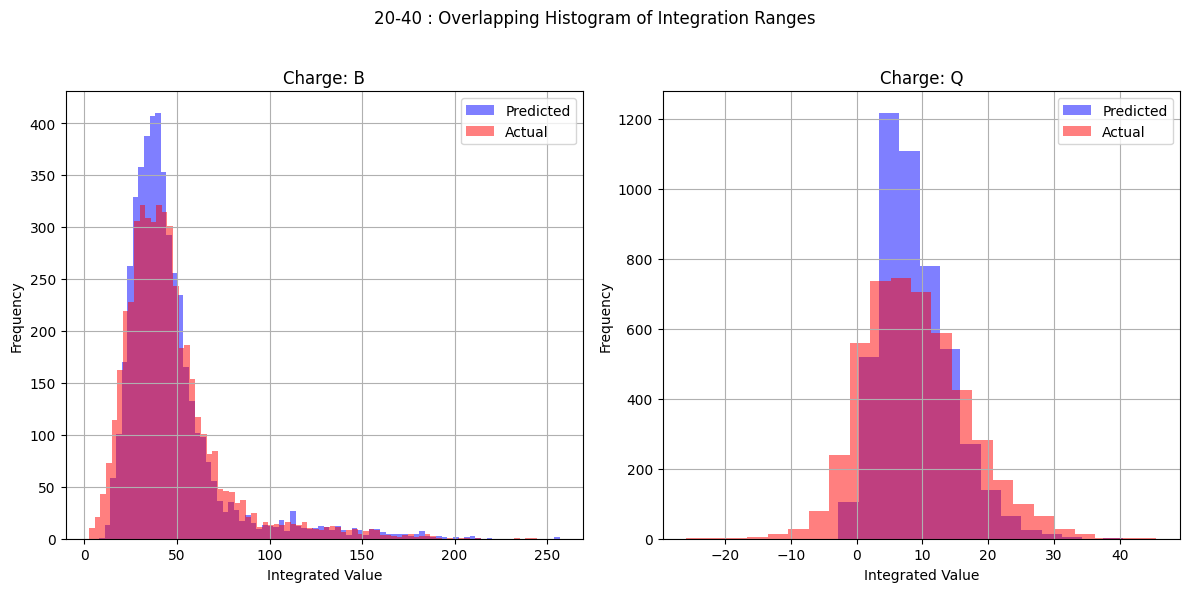

X_test: 38102
Check: 18820
0
actual 4764
pred 4764
1
actual 4684
pred 4684


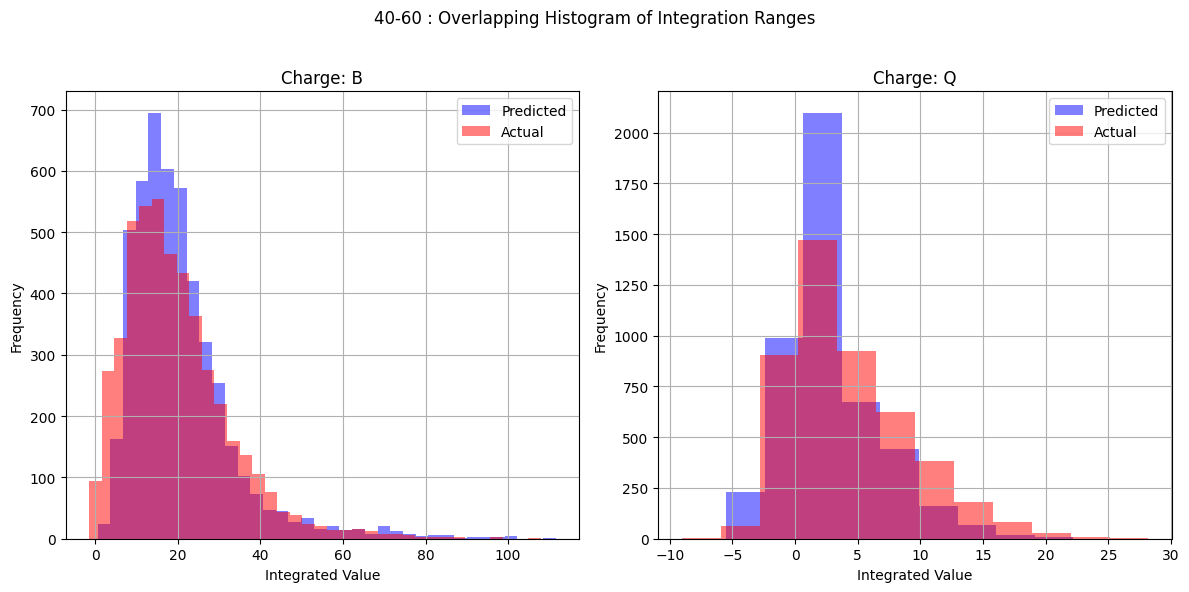

X_test: 38102
Check: 28268
0
actual 4852
pred 4852
1
actual 4982
pred 4982


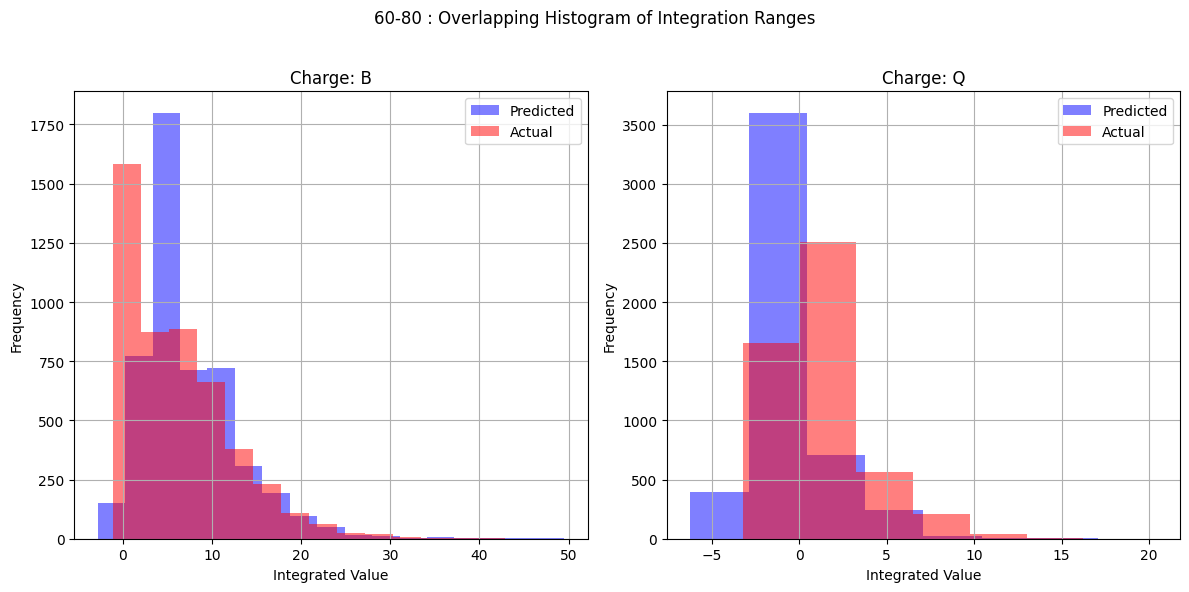

X_test: 38102
Check: 38102


In [38]:
lr_scaled = LinearRegression()
lr_scaled, X_t, y_t = finetune2(lr_scaled, X_train_1, y_train_1, X_test_1, y_test_1)
plot_error_norm2(lr_scaled, X_t, y_t, all_cent_test_1, all_charge_test_1)
plot_histograms2(lr_scaled, X_t, y_t, all_cent_test_1, all_charge_test_1)

Training completed in 312.79 seconds.
Mean Squared Error: 0.19609221621653317


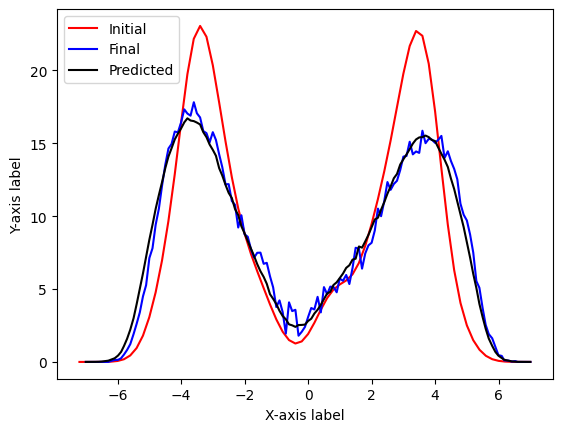

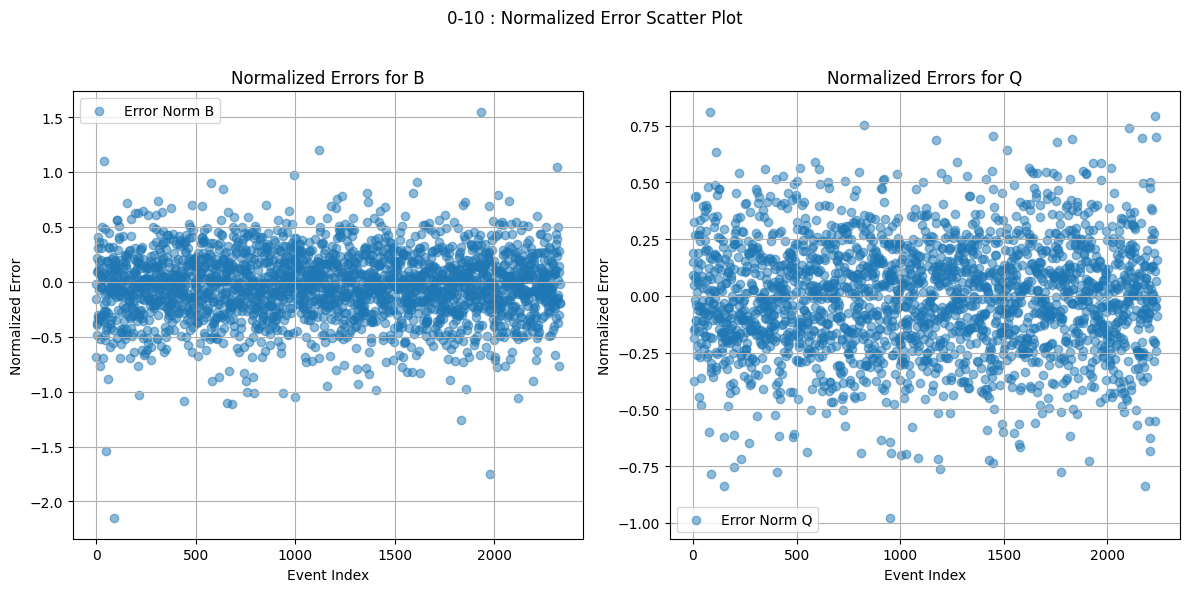

X_test: 38102
Check: 4571
Total >1 std dev: 17


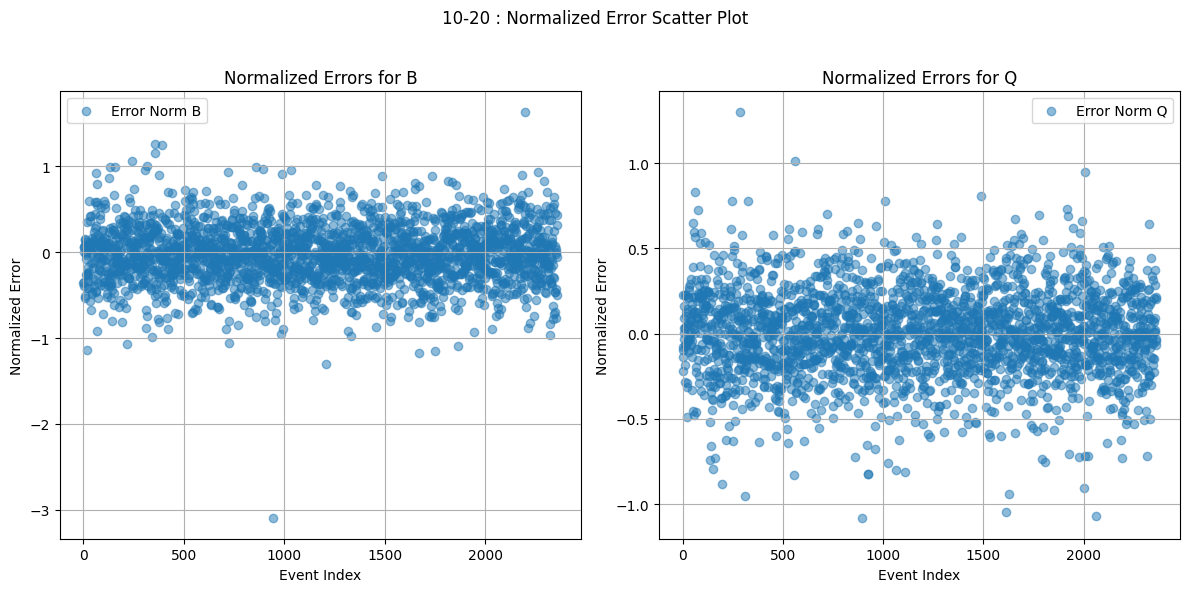

X_test: 38102
Check: 9293
Total >1 std dev: 18


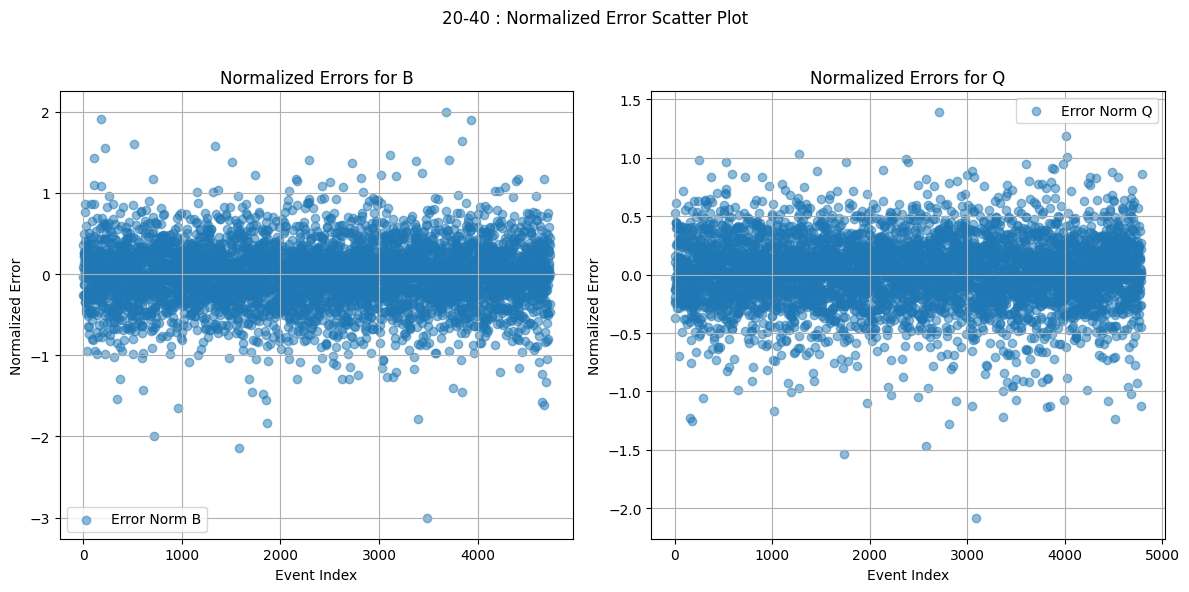

X_test: 38102
Check: 18820
Total >1 std dev: 115


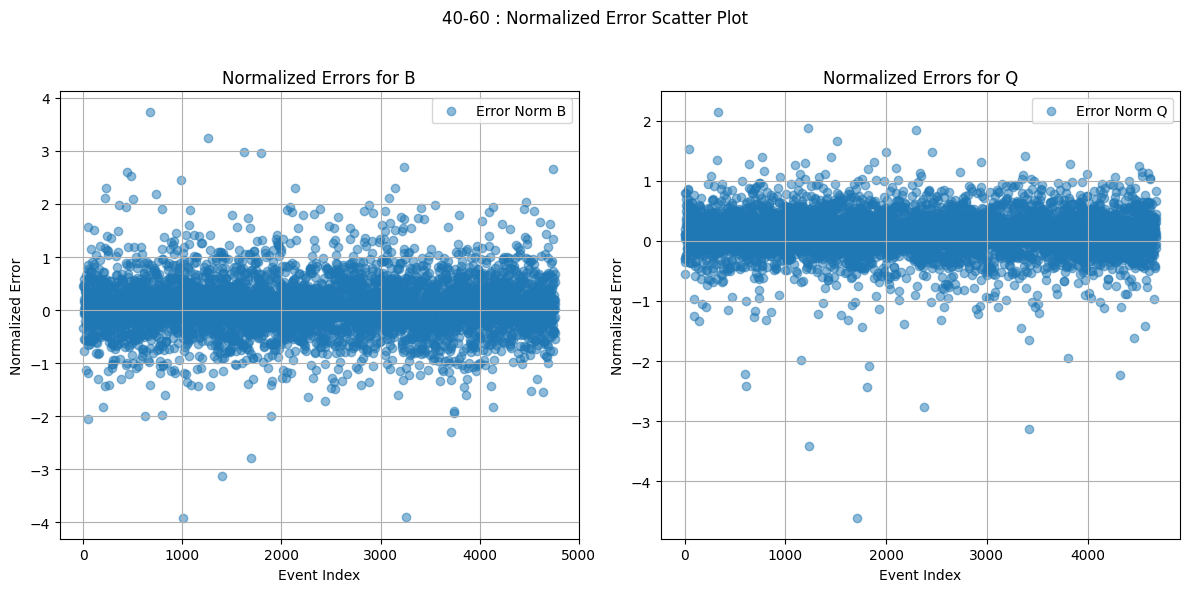

X_test: 38102
Check: 28268
Total >1 std dev: 402


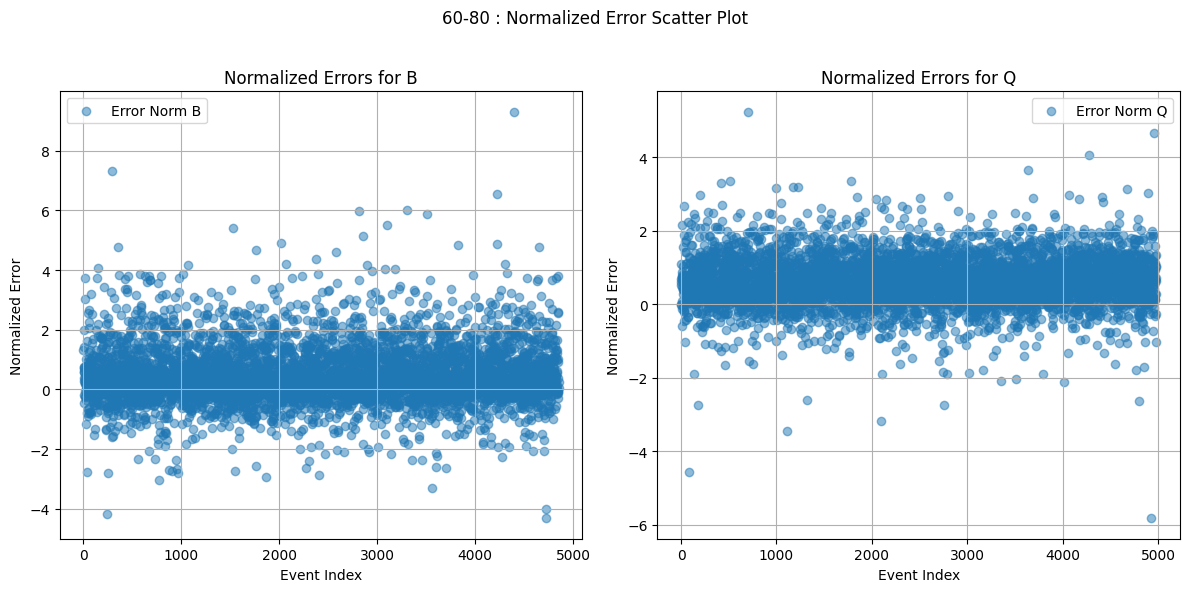

X_test: 38102
Check: 38102
Total >1 std dev: 2590
Total >1 std dev: 4862
0
actual 2332
pred 2332
1
actual 2239
pred 2239


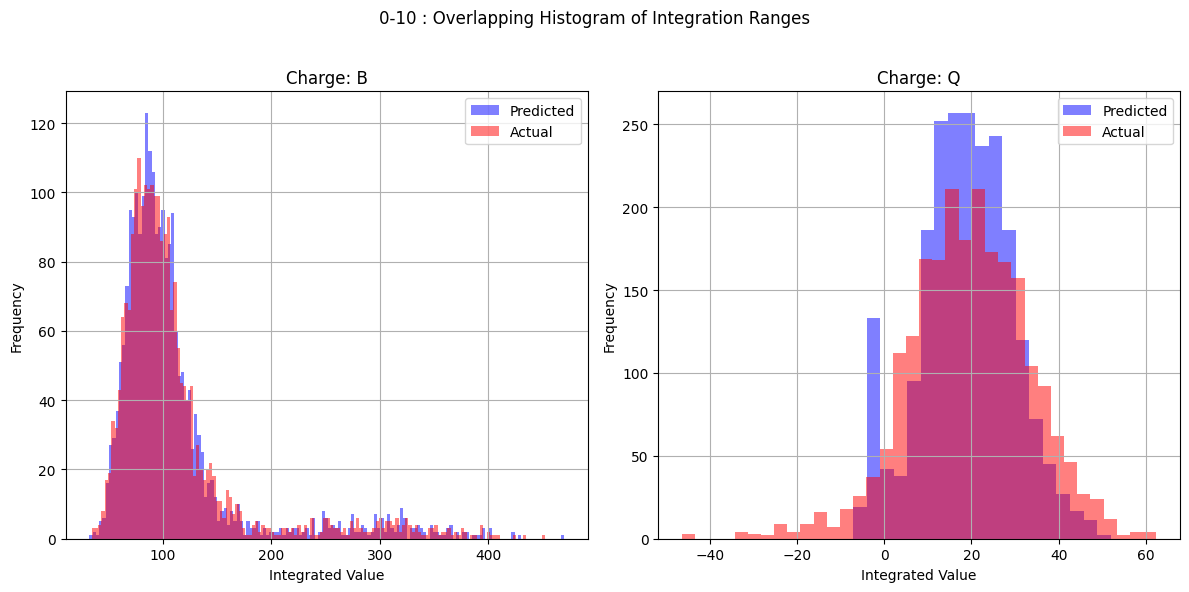

X_test: 38102
Check: 4571
0
actual 2358
pred 2358
1
actual 2364
pred 2364


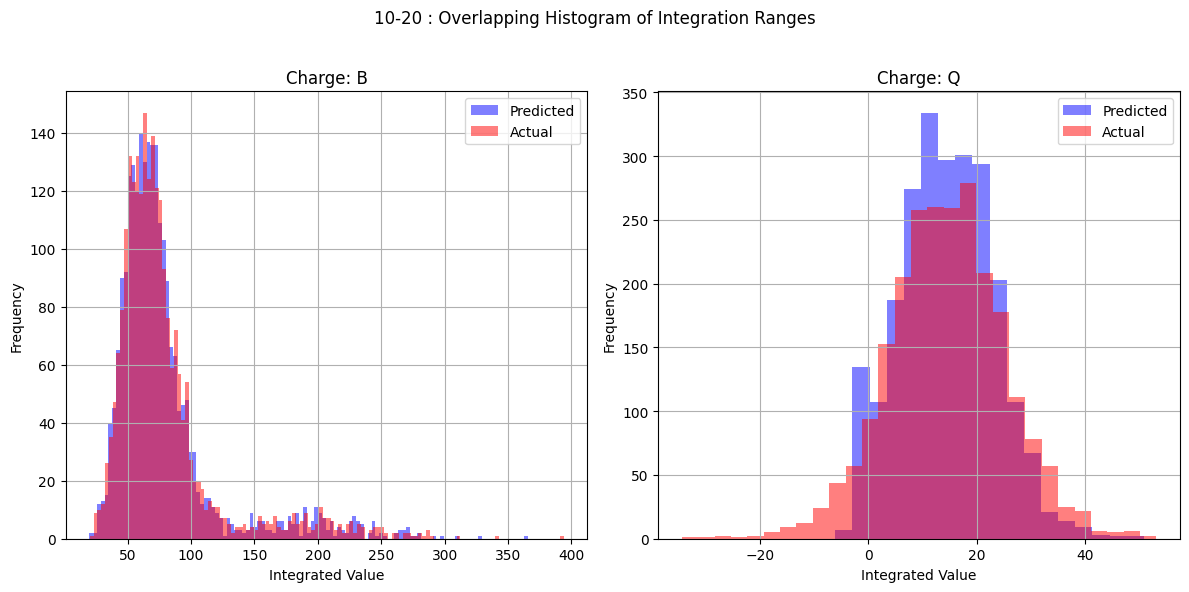

X_test: 38102
Check: 9293
0
actual 4736
pred 4736
1
actual 4791
pred 4791


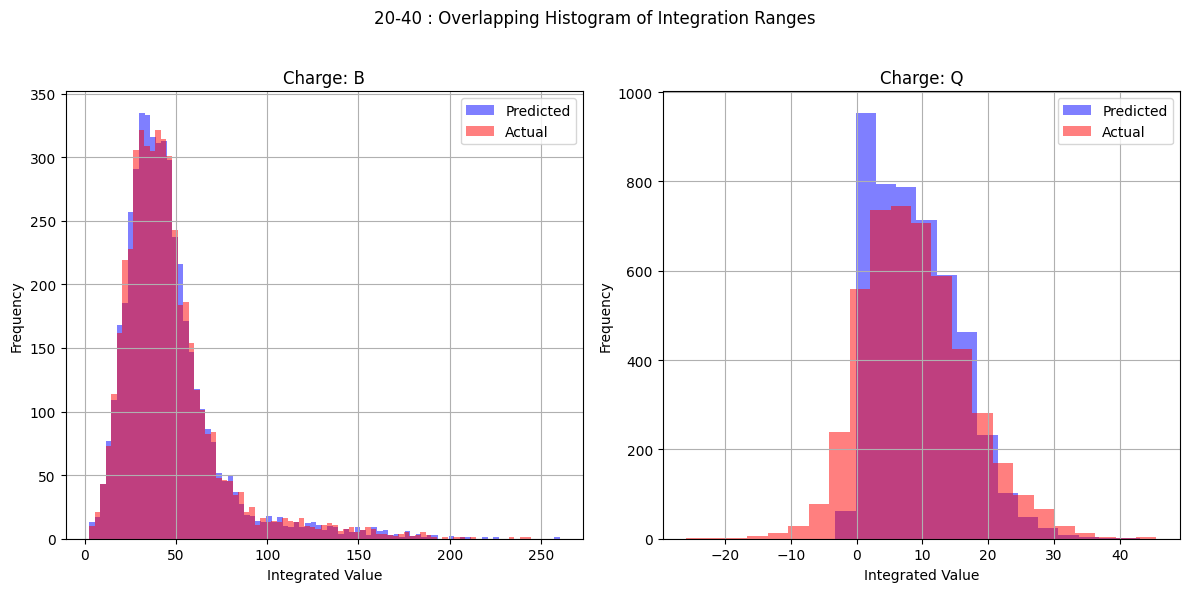

X_test: 38102
Check: 18820
0
actual 4764
pred 4764
1
actual 4684
pred 4684


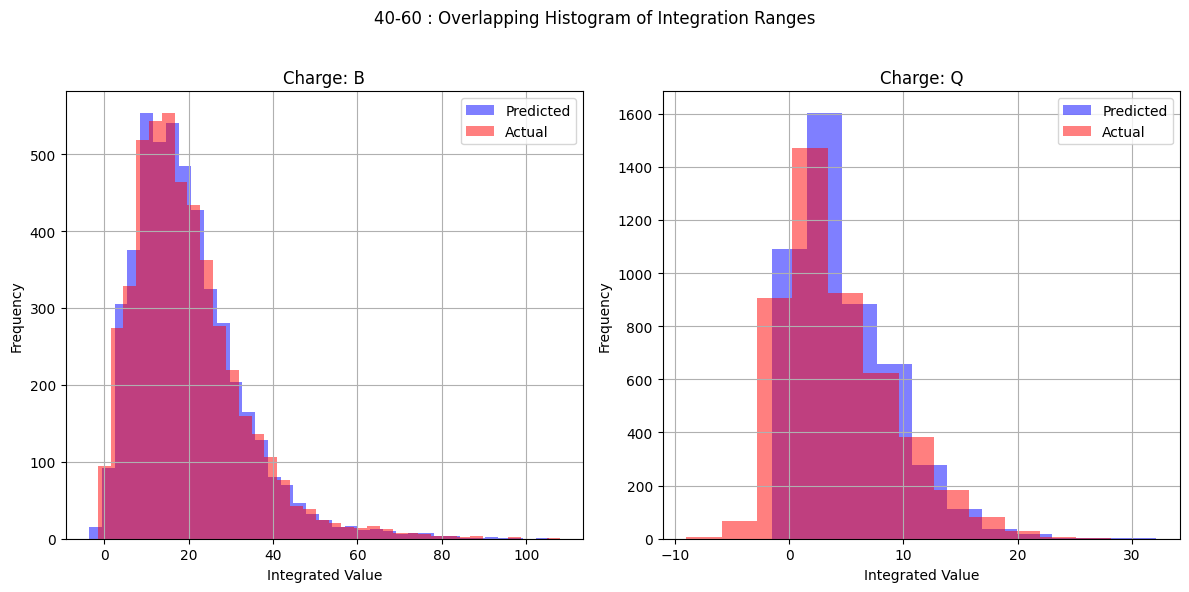

X_test: 38102
Check: 28268
0
actual 4852
pred 4852
1
actual 4982
pred 4982


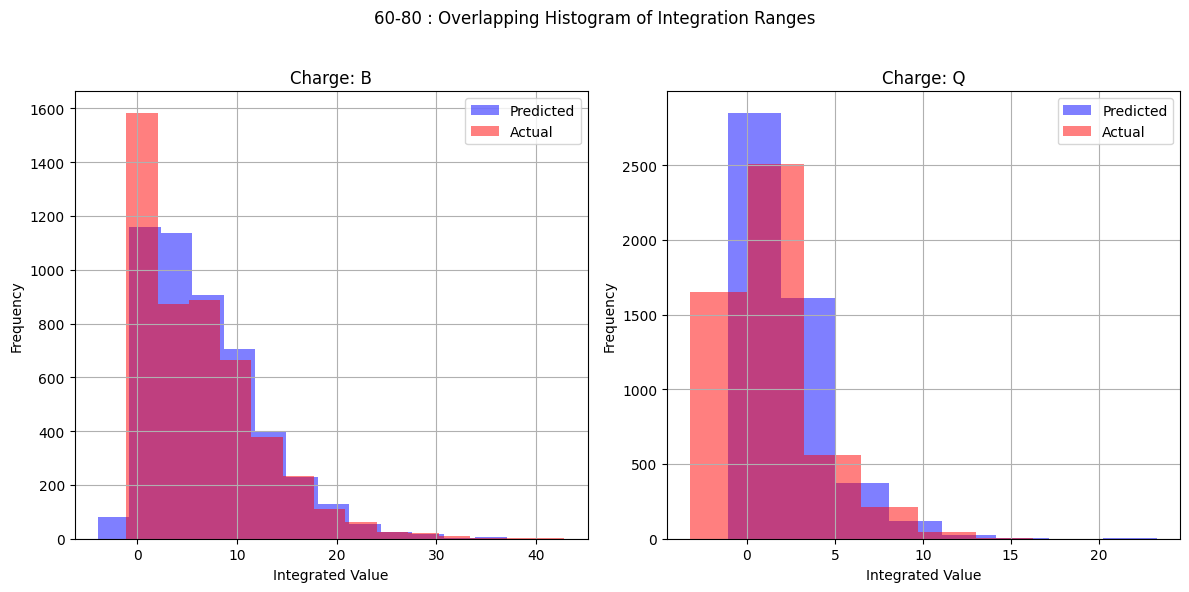

X_test: 38102
Check: 38102


In [39]:
mlp_scaled = MLPRegressor(hidden_layer_sizes = (100,100), max_iter = 500, random_state = 42)
mlp_scaled, X_t, y_t = finetune2(mlp_scaled, X_train_1, y_train_1, X_test_1, y_test_1)
plot_error_norm2(mlp_scaled, X_t, y_t, all_cent_test_1, all_charge_test_1)
plot_histograms2(mlp_scaled, X_t, y_t, all_cent_test_1, all_charge_test_1)